In [1]:
import numpy
import torch
import sys
print("Numpy version: ", numpy.__version__)
print("Torch version: ", torch.__version__)
print("Python version: ", sys.version)

Numpy version:  2.2.6
Torch version:  2.7.0+cu118
Python version:  3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]


In [2]:
import wandb
wandb.login()  
PROJECT_NAME = "RL-Portfolio-Management"

wandb: Currently logged in as: richardpogoson (richardpogoson-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 1. Collect Basic Data

### 1.1. Read/Download Market Data ###

In [3]:
import pandas as pd
import yfinance as yf
from functools import reduce
import numpy as np
import torch
import requests
import time
import numpy as np
import talib as ta
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


#########################################################################################
# Stock Details
sAndpTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "ULVR.L"]  
period = "1D"
indexProducts = sAndpTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

RETRIEVE_DATA = False
"""
NOTE ON DATA CONSISTENCY:
Yahoo finance value precision still a problem, but can be partly mitigated by rounding prices to 2dp.
I tried rounding indicators to 4 significant figures. 4 is arbitrary, but higher values
will likely lead to more instability.
Later testing revealed that these mitigation techniques helped a bit, but were not perfect. I did my best.

# DATA LAST RETRIEVED - June 7th 2025 - EMA rounded to 2dp. Tesla data issue fixed. Stricter validation.
"""
#########################################################################################


def retrieveIndexData(ticker, verbose=True):
    # Define date range
    startDate = "2009-01-01"  # same periods as that used by Zou et al. (2024)
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)

        # To have a more reliable indicator implementation. Mine were fine I believe, but the below is safer.
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]].copy()
        
        #Also round to 2dp to help reduce instability
        ohlcData[ticker][["Low", "High", "Open", "Close"]] = ohlcData[ticker][["Low", "High", "Open", "Close"]].round(2)

        high = np.round(stockData["High"].values.astype(np.float64).flatten(), 2)
        low = np.round(stockData["Low"].values.astype(np.float64).flatten(), 2)
        close = np.round(stockData["Close"].values.astype(np.float64).flatten(), 2)

        ohlcData[ticker]["ATR"] = ta.ATR(high, low, close, timeperiod=14)
        ohlcData[ticker]["Momentum"] = ta.MOM(close, timeperiod=1) # Momentum is used by Soleymani, not (RoC=Momentum Oscillator, my mistake)
        ohlcData[ticker]["CCI"] = ta.CCI(high, low, close, timeperiod=20)
        macd, signal, hist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        ohlcData[ticker]["MACD"] = macd # histogram isn't the same as the MACD line, also used by Zou, not Soleymani
        ohlcData[ticker]["EMA"] = np.round(ta.EMA(close, timeperiod=30), 2)  # Exponential Moving Average is a price moving average, so it should be rounded to 2dp as well 
        
        if verbose:
            print(f"\n{'-'*40}")
            print(f"Attempted to retrieve data for {ticker} from {startDate} to {endDate}")
            print(f"Actually retrieved data for {ticker} from {stockData.index[0].strftime('%Y-%m-%d')} to {stockData.index[-1].strftime('%Y-%m-%d')}")
            print(f"Data shape: {ohlcData[ticker].shape}")
            print(f"\n{ticker} - Indicator Data Lengths:")
            print(f"{'-'*40}")
            print(f"{'Close:':<20} {len(close)}")
            print(f"{'ATR:':<20} {len(ohlcData[ticker]['ATR'])}")
            print(f"{'CCI:':<20} {len(ohlcData[ticker]['CCI'])}")
            print(f"{'Momentum:':<20} {len(ohlcData[ticker]['Momentum'])}")
            print(f"{'EMA:':<20} {len(ohlcData[ticker]['EMA'])}")
            print(f"{'MACD:':<20} {len(macd)}")
            print(f"{'-'*40}\n")
            

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc

def roundToSf(array, sigFigs=4):
    """
    Round a NumPy array or Pandas Series to the specified number of significant figures
    Decision of 4 sigfigs is arbitrary, but higher values will likely lead to instability.
    """
    return np.array([
        round(x, sigFigs - int(np.floor(np.log10(abs(x)))) - 1) if x != 0 else 0 
        for x in array
    ])

def postProcessIndicators(df, columns):
    """
    Post-processes indicators - turns them to 4sf to promote stability
    """
    dfRounded = df.copy()
    for col in columns:
        if col in dfRounded.columns:
            dfRounded[col] = roundToSf(dfRounded[col])
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return dfRounded


dataframes = dict()


if RETRIEVE_DATA:
    for productId in productIds:
        """
        I was previously working with Crypto data also, so I implemented this to ensure
        column names are consistent across all dataframes.
        """
        dataframe = retrieveIndexData(ticker=productId)
        columnNames = [value[1] for value in list(dataframe.columns.values)]
        dataframe.columns = columnNames
        dataframes[productId] = dataframe
   
def verifyDataConsistency(dataframes, stage="None"):
    """
    Strictly verifies that all dataframes have the same columns (in the same order) 
    and the same index (ordered identically). Raises a ValueError if any inconsistency is found.
    
    Parameters:
        dataframes (dict): Dictionary where keys are identifiers (e.g., tickers) and values are pandas DataFrames.
        stage (str): A label (optional) to indicate at what stage this check is performed.
    
    Raises:
        ValueError: If any dataframe does not have the same columns or index as the first dataframe.
    """
    if not dataframes:
        raise ValueError("No dataframes to verify.")
    
    # Retrieve the columns and index from the first dataframe (in order)
    first_key = next(iter(dataframes))
    first_columns = list(dataframes[first_key].columns)
    first_index = list(dataframes[first_key].index)
    
    # Check each dataframe for consistency in columns and index
    for ticker, df in dataframes.items():
        # Ensure columns are identical in both names and order
        if list(df.columns) != first_columns:
            raise ValueError(
                f"Inconsistency at stage {stage}: DataFrame for '{ticker}' has columns {list(df.columns)} ; "
                f"expected {first_columns}."
            )
        # Ensure the index is identical in both values and order
        if list(df.index) != first_index:
            raise ValueError(
                f"Inconsistency at stage {stage}: DataFrame for '{ticker}' has index {list(df.index)} ; "
                f"expected {first_index}."
            )
    
    # If everything is consistent, you can optionally log success.
    print(f"All dataframes are consistent in terms of columns and index at stage {stage}.")


def dropNaN(data, logDroppedRows=True):
    # Create new dictionaries to store the cleaned data and the dropped rows
    cleanedData = {}
    droppedRows = {}

    for ticker, df in data.items():
        # Capture the indices of the rows which will be dropped
        clean_df = df.dropna()
        dropped_idx = df.index.difference(clean_df.index)
        
        # Store the cleaned dataframe and the dropped rows (as a DataFrame)
        cleanedData[ticker] = clean_df
        droppedRows[ticker] = df.loc[dropped_idx]

        # Optionally, print the dropped rows for debugging/inspection.
        if logDroppedRows and not droppedRows[ticker].empty:
            print(f"Dropped rows for ticker {ticker}:")
            print(droppedRows[ticker].head())  # Display only the first few rows for brevity
            print("-" * 80)
    return cleanedData

# Required for index data that pull stock data from different exchanges
def commonaliseAndPreprocess(data):
    """
    Returns data, ensures that all dataframes have the same index (dates).
    Also post-processes indicators returns 4 sigfigs.
    """
    data = dropNaN(data) # order of nan and commonalise switched - dropping NaNs first ensures that there are no gaps at beginning or end of data
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    verifyDataConsistency(data, stage="Commonalise (Post NaN Drop)")
    data = {ticker: postProcessIndicators(df, columns= ["ATR", "Momentum", "CCI", "MACD"]) for ticker, df in data.items()} # EMA is already rounded to 2dp, so we skip it here (as it is a price moving average)
    verifyDataConsistency(data, stage="Post-process Indicators")
    return data

if RETRIEVE_DATA:
    dataframes = commonaliseAndPreprocess(dataframes)

## ~~2. Augment Market Data With Indicators~~ - NOT REQUIRED, USING TALIB

## 3. Write/Load Dataframes to/from files

In [4]:
import os

if RETRIEVE_DATA:
    for product in productIds:
        """
        Generating dataframe for each product. Stored as marketdata.
        Now using reliable implementations of indicators from TA-Lib, as opposed to doing it myself.
        No longer have unstable indicators at the start of the dataframe, so we have 20 extra rows in total.
        """
        df = dataframes[product]
        df = df.drop(columns=['Open', 'High', 'Volume', 'Low'])
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first (index) column

times = None
for product in productIds:
    """
    Dropping the times column - is not required for training.
    """
    df = dataframes[product]
    times = df['Times']
    dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### 4.0.1. Comparison Strategies

In [5]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
sAndPBuyAndHold = np.array([0] + [1/len(sAndpTickers) if i in sAndpTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

"""
Non-RL Comparison Strategies
These are flat allocations across each of the respective indices.
"""
NON_RL_COMPARISON_STRATEGIES = {
    "SSE Buy-and-Hold": sse50BuyAndHold,
    "SENSEX Buy-and-Hold": sensexBuyAndHold,
    "FTSE 100 Buy-and-Hold": ftse100BuyAndHold,
    "S&P 500 Buy-and-Hold": sAndPBuyAndHold,
    "Buy-and-Hold All": buyAndHoldAll
}

### 4.0.2. Hyperparameters and Global Variables

In [6]:
from collections import defaultdict
import torch

BASE_SEED = 9
NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = 1 + (1 + len((list(dataframes.values())[0]).columns)) * len(productIds) + 1
PERIODS_WANTED = list(dataframes.values())[0].shape[0]
TRAINING_PERIODS = round(PERIODS_WANTED * 2 / 3)
VALIDATION_PERIODS = (PERIODS_WANTED - TRAINING_PERIODS) // 2
TESTING_PERIODS = VALIDATION_PERIODS


EPISODE_LENGTH = PERIODS_WANTED // 3 
TIMESTEP_SHIFT = EPISODE_LENGTH // 10
TRAINING_WINDOWS = ((TRAINING_PERIODS - EPISODE_LENGTH) // TIMESTEP_SHIFT) + 1


EPOCHS = 25
TIME_WINDOW = 30
PERTURBATION_NOISE = 0.01

SUM_TRAINING_PERIODS = TRAINING_WINDOWS * EPOCHS * (EPISODE_LENGTH - TIME_WINDOW) # because first time window steps are not used to learn
START_CASH = 10000  #lower for floating point precision of torch
LSTMHIDDENSIZE = 128

BASELINE = ["RANDOM"]
RL_STRATS = ["PPOLSTM"]
FINAL_STRATEGIES = BASELINE + list(NON_RL_COMPARISON_STRATEGIES.keys())
VARIED_BASE_SEEDS = [1, 3, 5, 7, 9]

AGENT_RISK_AVERSIONS = np.array([0.25, 0.5, 1, 1.5, 2]) #Different risk aversion parameters for the agent when using CVaR reward
LSTMOUTPUTSIZES = [32, 64, 128, 256, 512]
REWARD_FUNCTIONS = ["Differential Sharpe Ratio_0.01", "Differential Sharpe Ratio_0.05", "Differential Sharpe Ratio_0.1"]
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4]
LEARNING_FREQUENCIES = (EPISODE_LENGTH / np.array([10, 20, 30, 40, 50])).astype(int)

LEARNING_CURVE_FREQUENCY = None # for later
SCALE_LOG_REWARD = False
NORMALIZE_DATA = False
USE_NORMALS = False  




In [7]:
# Thing being tested
TESTING = {
    "RISK AVERSION" : False,
    "LSTM OUTPUT SIZE" : False,
    "REWARD FUNCTION" : False,
    "LEARNING FREQUENCY": False, 
    "LEARNING RATE": False,
}

### 4.0.3. Data Splitting

In [8]:
TRAINING_DATA = {}
VALIDATION_DATA = {}
TESTING_DATA = {}

for key, df in dataframes.items():
    """
    Splitting the data into training, validation and testing sets.
    """
    trainSlice = df.iloc[:TRAINING_PERIODS].copy()
    validationSlice = df.iloc[TRAINING_PERIODS:TRAINING_PERIODS+VALIDATION_PERIODS].copy()
    testSlice = df.iloc[TRAINING_PERIODS+VALIDATION_PERIODS:].copy()

    TRAINING_DATA[key] = trainSlice
    VALIDATION_DATA[key] = validationSlice
    TESTING_DATA[key]  = testSlice


TRAINING_VALIDATION_DATA = {}
# Join Training + Validation data set
for key, df in TRAINING_DATA.items():
    TRAINING_VALIDATION_DATA[key] = pd.concat([TRAINING_DATA[key], VALIDATION_DATA[key].copy()])
    TRAINING_VALIDATION_DATA[key] = TRAINING_VALIDATION_DATA[key].reset_index(drop=True)

#### 4.0.3.1 Data Visualisation

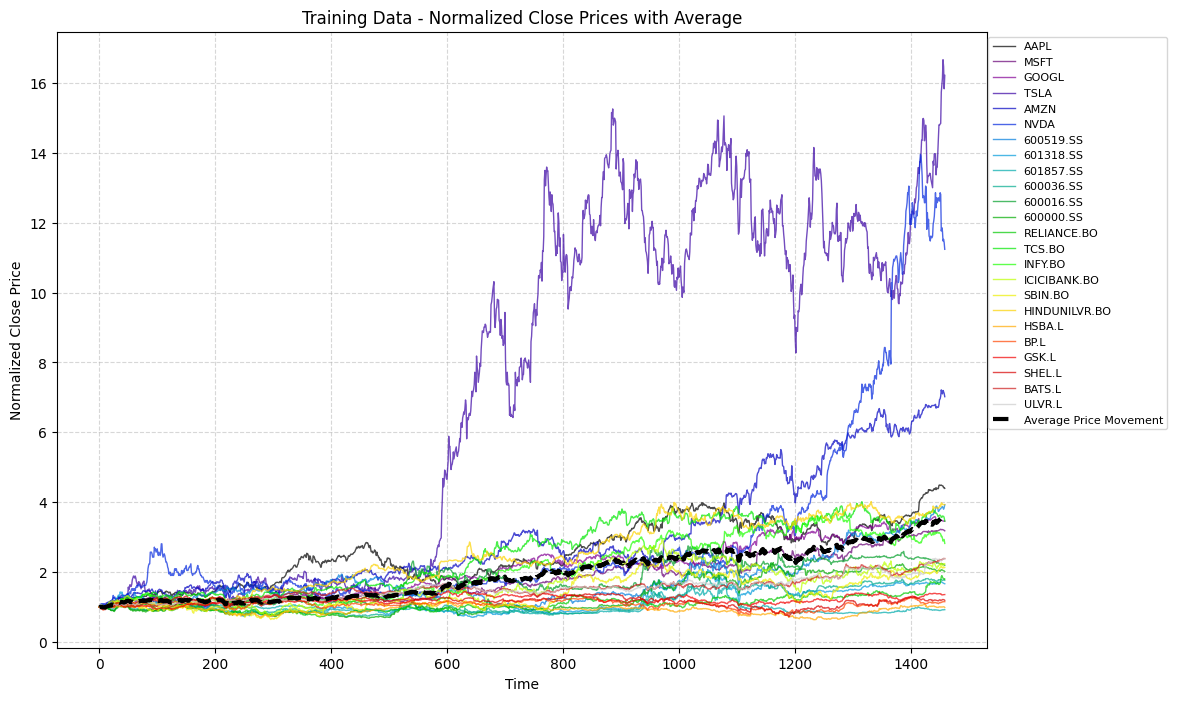

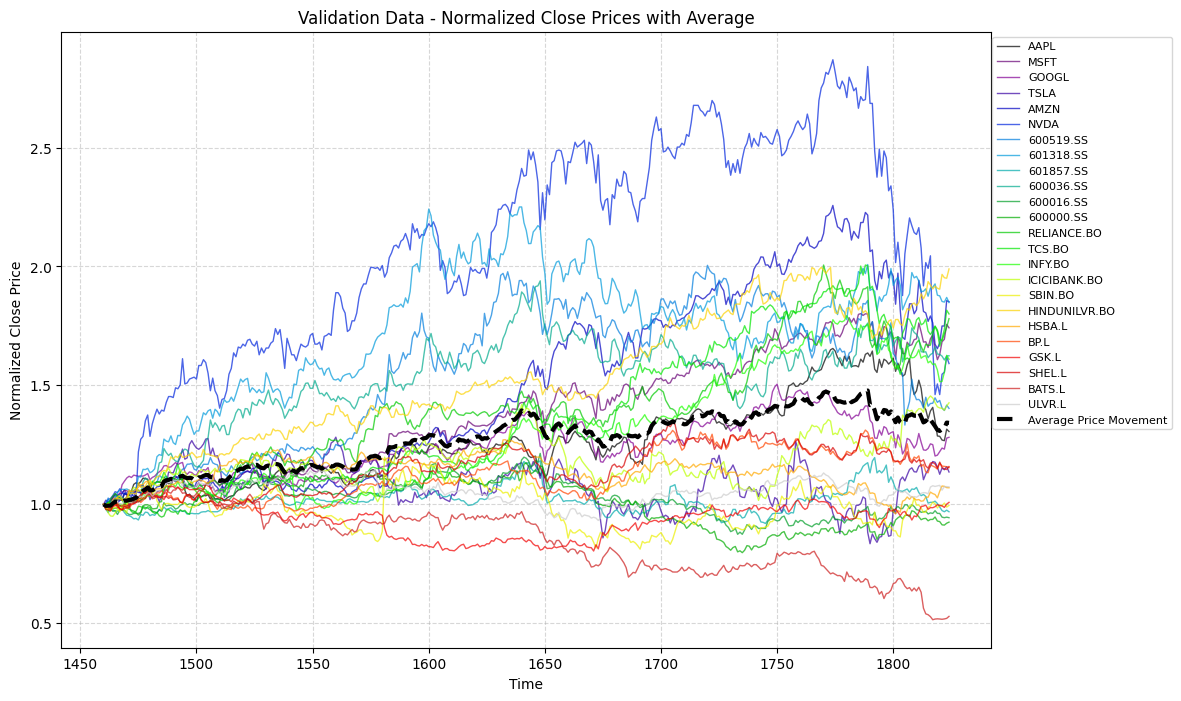

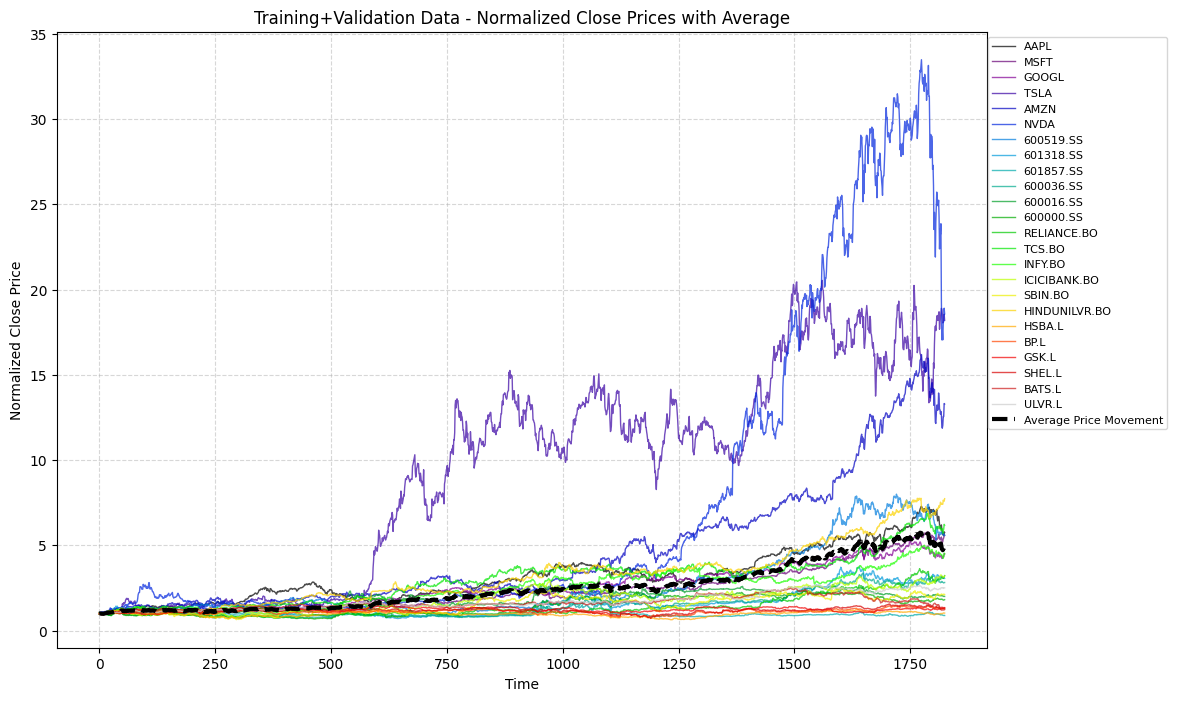

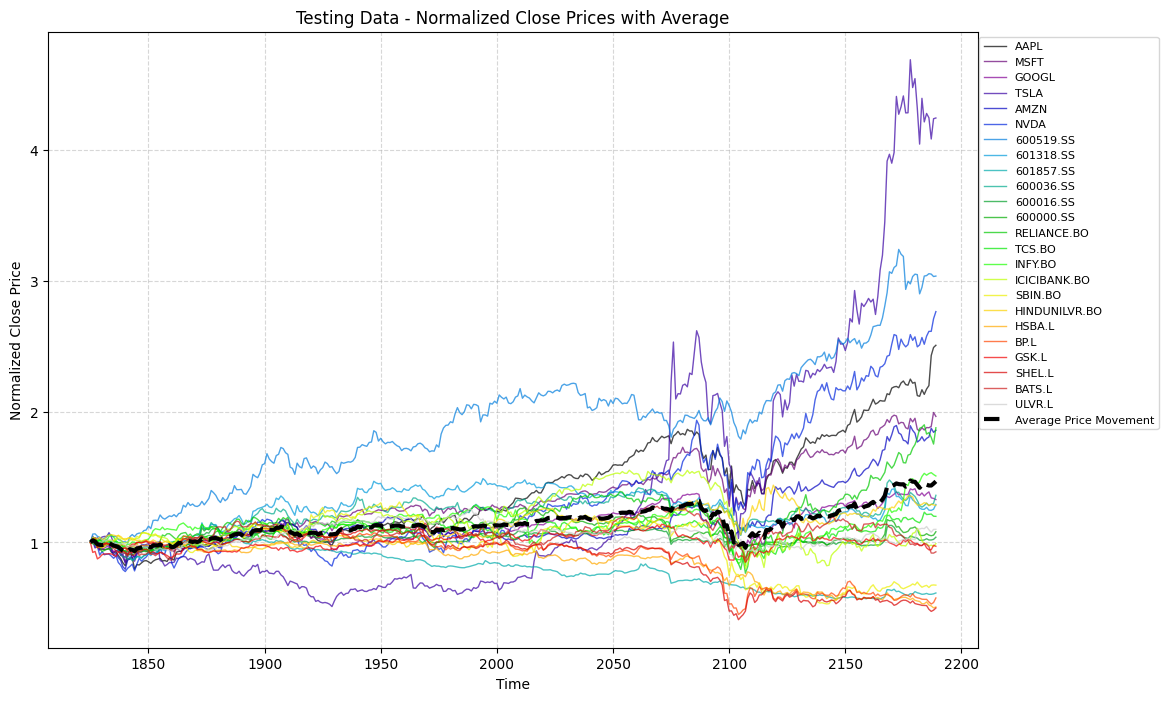

In [9]:
import matplotlib.pyplot as plt

# Create dictionary mapping descriptive names to their respective data dictionaries.
dataSetsMapping = {
    "Training Data": TRAINING_DATA,
    "Validation Data": VALIDATION_DATA,
    "Training+Validation Data": TRAINING_VALIDATION_DATA,
    "Testing Data": TESTING_DATA
}

# For each dataset type, plot normalized 'Close' prices from all keys on a single graph.
for setName, dfDict in dataSetsMapping.items():
    plt.figure(figsize=(12, 8))
    
    keys = list(dfDict.keys())
    
    # Set up a colormap with one color per key
    colourMap = plt.colormaps.get_cmap('nipy_spectral')
    colors = [colourMap(i / (len(keys) - 1)) for i in range(len(keys))]
    
    # Store normalized close values for averaging
    normalized_values = []

    # Plot individual key lines
    for idx, key in enumerate(keys):
        df = dfDict[key]
        normalizedClose = df["Close"] / df["Close"].iloc[0]  # Normalize by first value
        plt.plot(normalizedClose,
                 label=key,
                 alpha=0.7,
                 linestyle='solid',
                 linewidth=1,
                 color=colors[idx])
        normalized_values.append(normalizedClose)

    # Compute and plot the average price movement
    avg_price_movement = sum(normalized_values) / len(normalized_values)
    plt.plot(avg_price_movement, label="Average Price Movement", color="black", linewidth=3, linestyle='dashed')

    plt.xlabel("Time")
    plt.ylabel("Normalized Close Price")
    plt.title(f"{setName} - Normalized Close Prices with Average")
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=8, ncol=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

#### 4.0.4. Some helper functions for metrics

In [10]:
from utils import tabulate_neatly

def printConfiguration(agent=None, freq=None):
    table = [["LSTM Hidden Size", "LSTM Output Size", "Learning Frequency", "Agent Risk Aversion"]]
    table.append([LSTMHIDDENSIZE, agent.state_n, freq, agent.riskAversion])
    tabulate_neatly(table, headers="firstrow", title=f"Configuration:")

def plotAllocations(allocations, title=None):
    categories = ['Cash'] + productIds
    plt.figure(figsize=(20,5))
    plt.bar(categories, allocations)
    plt.xlabel('Allocations')
    plt.tick_params(axis='x', labelsize=6)
    plt.ylabel('Proportion Allocated')
    plt.title('Allocations' if title == None else title)
    plt.show()

def generateConfigLabel(strategy, agent, rewardFunction, freq, lr):
    """
    Helpful configuration label for each hyperparameter/reward function being tested.
    """
    firstTag = f"Strategy-{strategy}" 
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK AVERSION"]:
        innerTag = (f"Risk Aversion-{agent.riskAversion}" if boole else "")
    elif TESTING["LSTM OUTPUT SIZE"]:
        innerTag = (f"LSTM Output Size-{agent.state_n}" if boole else "")
    elif TESTING["REWARD FUNCTION"]:  
        innerTag = (f"Reward Function-{rewardFunction}" if boole else "")
    elif TESTING["LEARNING FREQUENCY"]:  
        innerTag = (f"Learning Frequency-{freq}" if boole else "")
    elif TESTING["LEARNING RATE"]:  
        innerTag = (f"Learning Rate-{lr}" if boole else "")
    
    if any(TESTING.values()) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | "

def logDetails(LOG_DETAILS):
    LOG_INPUT_DATA = LOG_DETAILS["inputData"][0]
    LOG_OBSERVATIONS = LOG_DETAILS["observations"][0]
    LOG_ACTIONS = LOG_DETAILS["actions"][0]
    dataOverTime = LOG_DETAILS["inputData"][1]
    observationsOverTime = LOG_DETAILS["observations"][1]
    actionsOverTime = LOG_DETAILS["actions"][1]
    if LOG_INPUT_DATA:
        plt.figure(figsize=(12, 8))  # Bigger figure for clarity
        for dim in range(dataOverTime[0].shape[0]):
            plt.plot(np.arange(len(dataOverTime)), np.array(dataOverTime)[:, dim], alpha=0.5)  # Adjust transparency to make it readable

        plt.xlabel("Time")
        plt.ylabel("Values per Index")
        plt.title("Data Over Time (using data index 0)")
        plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid for readability
        plt.show()
    if LOG_OBSERVATIONS:
        plt.figure(figsize=(12, 8))  # Bigger figure for clarity
        for dim in range(observationsOverTime[0].shape[0]):
            plt.plot(np.arange(len(observationsOverTime)), np.array(observationsOverTime)[:, dim], alpha=0.5)  # Adjust transparency to make it readable

        plt.xlabel("Time")
        plt.ylabel("Values per Index")
        plt.title("Observations Vectors Over Time")
        plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid for readability
        plt.show()
    if LOG_ACTIONS:
        plt.figure(figsize=(12, 8))
        labels = ['Cash'] + productIds

        colourMap = plt.colormaps.get_cmap('nipy_spectral')
        colors = [colourMap(i / (len(labels) - 1)) for i in range(len(labels))]

        for dim in range(actionsOverTime[0].shape[0]):
            plt.plot(np.arange(len(actionsOverTime)), 
                    np.array(actionsOverTime)[:, dim], 
                    label=labels[dim], 
                    alpha=0.7, linestyle='solid', linewidth=1, color=colors[dim])  # Corrected


        plt.xlabel("Time")
        plt.ylabel("Values per Index")
        plt.title("Actions Over Time")

        plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=8, ncol=1)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()


#### 4.1.1. Config Initialisation

In [11]:
def getConfig(phase, optionalHyperConfig=None):
    base = {
        "gamma": 0.99,
        "gae_lambda": 0.98,
        "clip_param": 0.2,
        "batch_size": EPISODE_LENGTH // 30, #median
        "fc1_n": 128,
        "fc2_n": 128,
        "lstm_output_size": 128,
        "epochs": 1, 
        "entropy_coef": 0.01,
        "learning_rate": 3e-4,
        "actor_noise": 0,
        "risk_aversion": 0,
        "reward_function": "Standard Logarithmic Returns",
        "norm_advantages": False,
        "use_entropy": False,
        "use_dirichlet": not USE_NORMALS,  # not implemented softmax correctly here
        "log_concentration": False, # log concentration parameters to wandb
    }

    if phase == "data_normalisation": # not advantage - Data
        return {
            **base,
            "lstm_hidden_sizes": {"actor": 512, "critic": 512, "feature" : 128},
            "log_concentration": False,  # optional - takes a million years to train
            "phase": "data_normalisation",
            "group": "Data Normalisation",
        }
    
    elif phase == "noise_testing":
        return {
            **base,
            "lstm_hidden_sizes": {"actor": 512, "critic": 512, "feature" : 128},
            "phase": "noise_testing",
            "group": "Noise Variation",#nicer name
        }
    
    
    # To be filled
    elif phase == "hyperparameter_tuning":
        return {
            **base,
            "lstm_hidden_sizes": {"actor": 512, "critic": 512, "feature" : 128},
            "learning_rate": optionalHyperConfig["learning_rate"] if optionalHyperConfig else 3e-4,
            "lstm_output_size": optionalHyperConfig["lstm_output_size"] if optionalHyperConfig else 128,
            "risk_aversion": optionalHyperConfig["risk_aversion"] if optionalHyperConfig else 0,
            "reward_function": optionalHyperConfig["reward_function"] if optionalHyperConfig else "Standard Logarithmic Returns",
            "learning_frequency": optionalHyperConfig["learning_frequency"] if optionalHyperConfig else 10,
            "phase": "hyperparameter_tuning",
        }
    
    elif phase == "reward_testing":
        return {
            **base,
            "lstm_hidden_sizes": {"actor": 512, "critic": 512, "feature" : 128},
            "phase": "reward_testing",
            "group": "Reward Function Variation",
        }

    else:
        raise ValueError(f"Unknown phase: {phase}")


getConfig("hyperparameter_tuning")  # Example call to check the function works

{'gamma': 0.99,
 'gae_lambda': 0.98,
 'clip_param': 0.2,
 'batch_size': 24,
 'fc1_n': 128,
 'fc2_n': 128,
 'lstm_output_size': 128,
 'epochs': 1,
 'entropy_coef': 0.01,
 'learning_rate': 0.0003,
 'actor_noise': 0,
 'risk_aversion': 0,
 'reward_function': 'Standard Logarithmic Returns',
 'norm_advantages': False,
 'use_entropy': False,
 'use_dirichlet': True,
 'log_concentration': False,
 'lstm_hidden_sizes': {'actor': 512, 'critic': 512, 'feature': 128},
 'learning_frequency': 10,
 'phase': 'hyperparameter_tuning'}

In [12]:
from PPO import PPOAgent
from LstmFeatureExtractor import LstmFeatureExtractor

def generateAgent(config, featureExtractor=None):
    """
    Generate a PPOAgent using config-driven parameters.
    Allows passing a custom feature extractor, otherwise creates an LSTM-based one.
    """
    if featureExtractor is None:
        featureExtractor = LstmFeatureExtractor(
            NUMBER_OF_FEATURES,
            lstmHiddenSize=config.get("lstm_hidden_sizes")["feature"],
            lstmOutputSize=128 # or whatever default
        )

    return PPOAgent(
        state_n=config.get("lstm_output_size", 128),
        actions_n=len(productIds) + 1,
        alpha=config["learning_rate"],
        policyClip=config.get("clip_param", 0.2),
        gamma=config.get("gamma", 0.99),
        lstmHiddenSizeDictionary=config.get("lstm_hidden_sizes"),
        actor_noise=config.get("actor_noise", 0),
        batch_size=config["batch_size"],
        fc1_n=config.get("fc1_n", 128),
        fc2_n=config.get("fc2_n", 128),
        gaeLambda=config.get("gae_lambda", 0.98),
        epochs=config.get("epochs", 1),
        riskAversion=config.get("risk_aversion", 0),
        featureExtractor=featureExtractor,
        maxSize=config["batch_size"],
        nonFeatureStateDim=(TIME_WINDOW, NUMBER_OF_FEATURES),
        entropyCoefficient=config.get("entropy_coef", 0.01),
        rewardFunction=config.get("reward_function", "Standard Logarithmic Returns"),
        normAdvantages=config.get("norm_advantages", False),
        useEntropy=config.get("use_entropy", False), 
        useDirichlet= config.get("use_dirichlet", True),
        log_concentration_heatmap=config.get("log_concentration", False)
    )


### 4.1.2. Evaluation Function

In [13]:
from TimeSeriesEnvironment import TimeSeriesEnvironment
import torch

LOG_OBSERVATIONS = False
LOG_ACTIONS = False
LOG_INPUT_DATA = False
LOG_ANY = LOG_OBSERVATIONS or LOG_ACTIONS or LOG_INPUT_DATA

def seed(seed):
    """
    General Seed function. Called at the start of each training run. 
    Ensures that all agents are initialised with the same weights.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for GPU

def normData(df, windowSize=TIME_WINDOW, actuallyNormalise = True):
    """
    Use Rolling zscore to normalise - might alter the meanings of indicators - LIMITATION
    1. Soleymani's would create temporal distortion (feature_i/feature_i-1) - 
    2. Liang et al. (2018) would create temporal leakage
    Ultimately, no normalisation method is perfect, so I will have to deal with this.
    TIME_WINDOW decision is brute.
    """
    # rolling mean normalisation
    # min periods = 1 may be a limitation
    if actuallyNormalise:
        rollingDf = df.rolling(window=windowSize, min_periods=1).mean()
        rollingStd = df.rolling(window=windowSize, min_periods=1).std() # usage of 1 is questionable but necesary

        rollingZScoreDf = (df - rollingDf) / (rollingStd + 1e-8)

        rollingZScoreDf.columns = df.columns  
        return rollingZScoreDf # temporarily removing normalisation!!! #rollingZScoreDf.fillna(0) # fill NaNs with 0s, forced
    return df

def storeExperiences(agent, data, reward, done, strategy, action, prob, val, hiddenAndCStates=None):
    """
    Store experiences in the agent's memory. This is used for the PPO agents.
    """
    if strategy == "PPOLSTM":
        agent.store(data, action, prob.squeeze(), val.squeeze(), reward, done, hiddenAndCStates)


def warmUpEnvironment(environment, rewardFunction):
    """
    'warm up' environment until there's enough data to estimate CVaR
    and to create a long enough time window to pass to the lstm. 
    For the lstm, this is not critical but considering a time window 
    required to estimate CVaR, I thought it fair to ensure this for all agents.
    """
    for _ in range(TIME_WINDOW):
        environment.step(np.ones(len(productIds) + 1)/(len(productIds) + 1), rewardMethod=rewardFunction)
    environment.setIsReady(True)


def hiddenStateReset(agent):
    """
    Resets the hidden states of the agent and feature extractor.
    This is called at the start of any training/testing episode
    to prevent temporoal leakage.
    """
    hAndCStates = dict()
    hAndCStates["actor"] = agent.actor.initHidden(batchSize=1)
    hAndCStates["critic"] = agent.critic.initHidden(batchSize=1)
    hAndCStates["feature"] = agent.featureExtractor.initHidden(batchSize=1)
    return hAndCStates

def evaluateAgent(riskAversion, rewardFunction, agent, freq, lr, num, conf=None, save=True, dataType = "validation", forLearningCurve=False, benchmark=False, epoch=0, showTable=False, compare=None, useNoiseEval=True):
    """
    Evaluation function. This is called:
     1. During Noise Testing: After every episode to create a training learning curve with respect to each noise level
        - here noise is added to the training data, but not the validation data so we can see the effect of noise on the agent's training with a proper baseline
     2. During Normal Training: Once per epoch to provide visible training progress (if any)
        - Noise is added to the validation data this time, but this is not included in the results and is a visible sign of progress (if any)
     3. During hyperparameter evaluation: 10 times per epoch on noised evaluation data, per hyperparameter to properly provide a benchmark for the hyperparameter
        - Here, noise is added, seeded by each repetition. The results for a given hyperparameter epoch are averaged and used for assessment calculations     
     4. During testing: Every hundredth of the total training time on unnoised test data to generate a learning curve.
        - Here, no noise is added to the test data. It is properly "out of sample" and is used to assess the agent's performance on unseen data.
    """
    
    VAL_AND_TEST = {
        "validation": [VALIDATION_DATA, VALIDATION_PERIODS],
        "testing": [TESTING_DATA, TESTING_PERIODS]
    }
    # this was a pain to write
    toRun = RL_STRATS if not useNoiseEval else BASELINE + RL_STRATS if not forLearningCurve else RL_STRATS
    if benchmark:
        """
        slightly misleading. If using the random agent as a benchmark, the random agent is seeded by that 
        repetition to ensure that many random seeds are used for it
        """
        np.random.seed(BASE_SEED + epoch) 
        toRun = BASELINE
    if compare != None:
        """
        An optional comparison strategy. This is used to compare the agent's performance against an index.
        """
        strategy = compare
        toRun = [strategy]
    DATA = VAL_AND_TEST[dataType][0]
    dataShape = list(DATA.values())[0].shape  
    PRICE_DATA = {}
    normalisedData = {}
    if dataType == "validation": # noise if validation
        # Following Liang et al. (2018) - noise perturbation - "synthetic" data
        noise = 0
        if useNoiseEval:
            """
            if using noise here - seed it by the epoch. This is to ensure that the noise is consistent across a given epoch for all hyperparameters
            """
            np.random.seed(BASE_SEED + epoch) 
            noise = np.random.normal(0, PERTURBATION_NOISE, size=dataShape)
    for key, dframe in DATA.items():
        df = dframe.copy()
        df.reset_index(drop=True)
        if dataType == "validation":
            # only add noise if validation data. Else (if testing) do not.
            df += noise * df.std().values # make autoregressive?
        df["Return"] = df["Close"].pct_change().fillna(0)
        PRICE_DATA[key] = df["Return"].values
        normalisedData[key] = normData(df, actuallyNormalise=NORMALIZE_DATA) # currently not normalisiing - normalisation makes it look noisy and removes indicator information
           
    for strategy in toRun:
        env = TimeSeriesEnvironment(pd.DataFrame(PRICE_DATA), normalisedData, TIME_WINDOW, VAL_AND_TEST[dataType][1], START_CASH, riskAversion, 2e-4, scaleLogReward=SCALE_LOG_REWARD)
        env.reset()
        done = False
        if strategy in RL_STRATS:
            """
            Reset hidden and cell states of the agent and feature extractor.
            """
            hiddenAndCellStates = hiddenStateReset(agent)
        observationsOverTime = []
        actionsOverTime = []
        dataOverTime = []
        while not done:
            if strategy not in NON_RL_COMPARISON_STRATEGIES:
                if not env.getIsReady():
                    """
                    If the strategy being tested is random/PPO, warm up the environment (to ensure that they both have the same starting point)
                    """
                    warmUpEnvironment(env, rewardFunction)
            observation = None
            if strategy in RL_STRATS:
                data = env.getData() # Retrieve data
                dataOverTime.append(data.squeeze(0)[0].detach().cpu().numpy())
                observation, hiddenAndCellStates["feature"] = agent.featureExtractor.forward(data, hiddenAndCellStates["feature"])
                if LOG_OBSERVATIONS:
                    observationsOverTime.append(observation.detach().cpu().numpy())
            if strategy == "RANDOM":
                """Random agent samples actions from a Dirichlet distribution - The same as that used in the PPO agent for consistency."""
                action = np.random.dirichlet(np.ones(len(productIds) + 1))
            elif strategy in NON_RL_COMPARISON_STRATEGIES:
                action = NON_RL_COMPARISON_STRATEGIES.get(strategy)
            else: 
                if strategy == "PPOLSTM":
                    action, _, __, actorHidden, criticHidden = agent.select_action(observation, hiddenAndCellStates, sampling= False, returnHidden= True)
                    if LOG_ACTIONS:
                        actionsOverTime.append(action.detach().cpu().numpy())
                    hiddenAndCellStates["actor"] = actorHidden  # #update and cell states of actor
                    hiddenAndCellStates["critic"] = criticHidden # update and cell states of critic
            next, reward, done, _, info = env.step(action, rewardFunction, returnNextObs=False) # the reward is not observed during evaluation, since the agent does not learn from the data, further, nextobs is not required since no GAE                    
        
        dataString = None
        
        if strategy == "PPOLSTM":
            if LOG_ANY:
                #Dictionary of boolean flags to data to log
                LOG_DETAILS = {
                    "observations": [LOG_OBSERVATIONS, observationsOverTime],
                    "actions": [LOG_ACTIONS, actionsOverTime],
                    "inputData": [LOG_INPUT_DATA, dataOverTime]
                }
                logDetails(LOG_DETAILS)
        
        if strategy in NON_RL_COMPARISON_STRATEGIES or (not useNoiseEval and strategy in RL_STRATS):
            # Sometimes it is necessary (when not saving models) to simply return the portfolio values
            return env.PORTFOLIO_VALUES
        
        if not benchmark:
            if conf == None or strategy == "RANDOM":
                # Helpful configuration label for each hyperparameter/reward function being tested.
                dataString = generateConfigLabel(strategy, agent, rewardFunction, freq, lr)
            else:
                dataString = conf
        
        if not forLearningCurve:
            if not benchmark:
                if showTable:
                    # Tabulation code - helps to see performance metrics for a given evaluation episode
                    metrics = env.getMetrics()
                    table = [metrics.keys()]
                    table.append(metrics.values())
                    tabulate_neatly(table, headers="firstrow", title=f"Evaluation: {num} | {dataString}")
            else:
                return env.PORTFOLIO_VALUES
        
        """
        The below is a lot of 'saving' code, for saving models and portfolio trajectories where necessary
        """
        portFolder = f"portfolios/{dataType}/{num}/"
        if forLearningCurve:
            portFolder = f"portfolios/{dataType}/forLearningCurve{BASE_SEED}/"
        if not os.path.exists(portFolder):
            os.makedirs(portFolder)
        filePath = f"{portFolder}{(dataString.split("|")[0]).strip()}.txt"
        if forLearningCurve:
            filePath = f"{portFolder}{(dataString.split('|')[0]).strip()}_{num}.txt"
            np.savetxt(filePath, env.PORTFOLIO_VALUES, fmt='%f')
        if (strategy in RL_STRATS) and save:
            saveFolder = f"save/{dataType}/{num}/{(dataString.split("|")[0]).strip()}/"
            # Ensure the child save directory exists
            if not os.path.exists(saveFolder):
                os.makedirs(saveFolder)
            agent.save(saveFolder)
              
    return env.PORTFOLIO_VALUES # VERY hacky - returns portfolio values for rl strat
            

### 4.1.3. Training Loop

In [14]:
from PPO import PPOAgent
from LstmFeatureExtractor import LstmFeatureExtractor
import numpy as np


def initialiseTrainingEnvironment(episode, rewardFunction, riskAversion, evalType, epoch):
    """
    Training environment initialization function. From the base training data, we 
    generate a slightly perturbed version of the orignal training data, ensuring
    that the noise added is dependent on both the episode and the epoch.
    This ensures that no two episodes out of a whole training run are the same, even 
    if they cover the same base periods from the initial training data.
    """
    start = TIMESTEP_SHIFT * episode
    
    datasets = {
        "validation": {
            "TRAINING_DATA": TRAINING_DATA,
        },
        "testing": { # use traingin and validation data combo for testing
            "TRAINING_DATA": TRAINING_VALIDATION_DATA,
        }
    }
    DATA = datasets[evalType]["TRAINING_DATA"]
    dataShape = list(DATA.values())[0].shape 
    end = min(start+EPISODE_LENGTH, dataShape[0])
    dataWindow = {}
    for key, value in DATA.items():
        dataWindow[key] = value.iloc[start:end].copy()
    
    np.random.seed(BASE_SEED + episode * 100 + epoch) # each episode has a different seed
    NOISY_PRICE_DATA = {}
    normalisedData = {}
    for key, dframe in dataWindow.items():
        df = dframe.copy()
        df = df.reset_index(drop=True)
        # Following Liang et al. (2018) - noise perturbation - "synthetic" data
        noise = np.random.normal(0, PERTURBATION_NOISE, size=(end - start, dataShape[1])) * df.std().values
        df += noise # make autoregressive?
        df["Return"] = df["Close"].pct_change().fillna(0)
        NOISY_PRICE_DATA[key] = df["Return"].values 
        normalisedData[key] = normData(df, actuallyNormalise=NORMALIZE_DATA) 
    env = TimeSeriesEnvironment(pd.DataFrame(NOISY_PRICE_DATA), normalisedData, TIME_WINDOW, EPISODE_LENGTH, START_CASH, riskAversion, 2e-4, scaleLogReward=SCALE_LOG_REWARD)
    if "Differential" in rewardFunction:
        decay = float(rewardFunction.split("_")[1])
        env.decayRate = decay
    return env

def trainingLoop(ppoAgent, conf = None, evalType = "validation", useNoiseEval=True, save=True):
    """
    The above parameters are for specifying which agent/hyperparameter is being trained. The above ones used are default.
    The risk aversion being 0 ensures that when not testing the risk aversion, the agent learns from the logarithmic return function
     - if you check the timeseries environmetn code, it will be noticed that a risk aversion of 0 simply results in the logarithmic return function being used.
    """

    trainingMetrics = {
        "epoch_reward": [], # to store validtion set peformances when noise testing
        "validation_performances": [] # to store total rewards for each training episode
    }

    agent = ppoAgent # might want to change name if things get better
    numberRun=0
    totalTimesteps = 0
    startTime = time.time() # just to time epochs
    for epoch in range(EPOCHS):
        print("Epoch:", epoch)
        if epoch > 0:
            print(f"{epoch} Epochs takes: {(time.time() - startTime):.2f} seconds")    
        for strategy in RL_STRATS:
            """
            Much of the rest of the code follows a similar structure to the evaluation function, except for training.
            """
            previousReward = 0
            totalReward = 0
            for episode in range(TRAINING_WINDOWS):
                print("Episode:", episode, "Strategy:", strategy)
                env = initialiseTrainingEnvironment(episode, agent.rewardFunction, agent.riskAversion, evalType, epoch)
                env.reset()
                hiddenAndCellStates = hiddenStateReset(agent)
                done = False
                while not done:
                    if not env.getIsReady():
                        warmUpEnvironment(env, agent.rewardFunction)
                        continue
                    observation = None
                    data = env.getData()
                    if strategy == "PPOLSTM":
                        prevHiddenAndCellStates = hiddenAndCellStates.copy() # save previous hidden and cell states (for storing)
                    observation, hiddenAndCellStates["feature"] = agent.featureExtractor.forward(data, hiddenAndCellStates["feature"])
                    probabilities, valuation = None, None
                    if strategy == "PPOLSTM":
                        action, probabilities, valuation, actorHidden, criticHidden = agent.select_action(observation, hiddenAndCellStates, returnHidden=True)
                        hiddenAndCellStates["actor"] = actorHidden  # returned from agent
                        hiddenAndCellStates["critic"] = criticHidden
                    next, reward, done, _, info = env.step(action, agent.rewardFunction)   
                    totalReward += reward 
                    totalTimesteps += 1                
                    if strategy in RL_STRATS:
                        storeExperiences(agent, data, reward, done, strategy, action, probabilities, valuation, prevHiddenAndCellStates if strategy == "PPOLSTM" else None)
                        if agent.memory.ptr % agent.memory.maxSize == 0: # Train when the batch is full - following Zou et al. (2024) with their single epoch training loop.
                            agent.train(next, hiddenAndCellStates) # required for proper GAE
                        if evalType == "testing" and (totalTimesteps % LEARNING_CURVE_FREQUENCY == 0):
                            evaluateAgent(agent.riskAversion, agent.rewardFunction, agent, agent.memory.maxSize, agent.alpha, int(totalTimesteps/LEARNING_CURVE_FREQUENCY), conf, dataType=evalType, save=False, forLearningCurve=True)
                    if done:
                        numberRun += 1
                        print("Episode Reward:", totalReward-previousReward)
                        wandb.log({"total_reward": totalReward}, commit=False)
                        previousReward = totalReward
                        if useNoiseEval: #if not doing noise testing, only evaluate once per epoch
                            if numberRun % TRAINING_WINDOWS == 0:
                                evaluateAgent(agent.riskAversion, agent.rewardFunction, agent, agent.memory.maxSize, agent.alpha, numberRun, conf, dataType=evalType, epoch=epoch, showTable = True, useNoiseEval=True)
                        else: # if doing noise testing, evaluate at he end of each training ep
                            portTrajectory = evaluateAgent(agent.riskAversion, agent.rewardFunction, agent, agent.memory.maxSize, agent.alpha, numberRun, conf, dataType=evalType, epoch=epoch, showTable = True, useNoiseEval=False, save=False)
                            trainingMetrics["validation_performances"].append(portTrajectory[-1]/START_CASH)
                            wandb.log({"evaluation_performances": trainingMetrics["validation_performances"][-1]}, commit=False)
            trainingMetrics["epoch_reward"].append(totalReward)    
    return trainingMetrics if not useNoiseEval else None
                            
                        

#### 4.2. Effect of Normalisation on Data (Rolling Z-Score)

In [15]:
portVals = dict()
normalisationFolder = "portfolios/Normalisation/"
EPOCHS = 25 # approx 200k timesteps

NORMALIZE_DATA = True
PERTURBATION_NOISE = 0 #Just seeing if it can even fit to the data

NORM_TESTING = False 
if NORM_TESTING:
    for s in VARIED_BASE_SEEDS:
        BASE_SEED = s
        phase = "data_normalisation"
        cfg = getConfig(phase)
        seed(BASE_SEED) # Seed agent initialization and updates
        wandb.init(
                    project=PROJECT_NAME,
                    config=cfg,
                    name=f"exp-{phase}"
                        + ("_NO_" if not SCALE_LOG_REWARD else "") + "SCALING"
                        + ("_NORM" if NORMALIZE_DATA else ""),
                    reinit=True,
                    group=cfg["group"],
                    mode="online" 
                )
        config = wandb.config

        agent = generateAgent(config)

        if wandb.run is not None:
            wandb.watch(agent.actor, log="all")
            wandb.watch(agent.critic, log="all")
            wandb.watch(agent.featureExtractor, log="all")

        print("*" * 50)
        print("Testing Seed: " , s)
        portVals[s] = trainingLoop(agent, useNoiseEval=False, save=False)
        desiredFolder = f"{normalisationFolder}{s}/"
        if not os.path.exists(desiredFolder):
            os.makedirs(desiredFolder)
        np.savetxt(f"{desiredFolder}validationPerformances.txt", portVals[s]["validation_performances"], fmt='%f')
        np.savetxt(f"{desiredFolder}trainingRewards.txt", portVals[s]["epoch_reward"], fmt='%f')
        
        print("*" * 50)
        wandb.finish()

NORMALIZE_DATA = False

EPOCHS = 25

#### 4.2.1 Normalisation Plotted

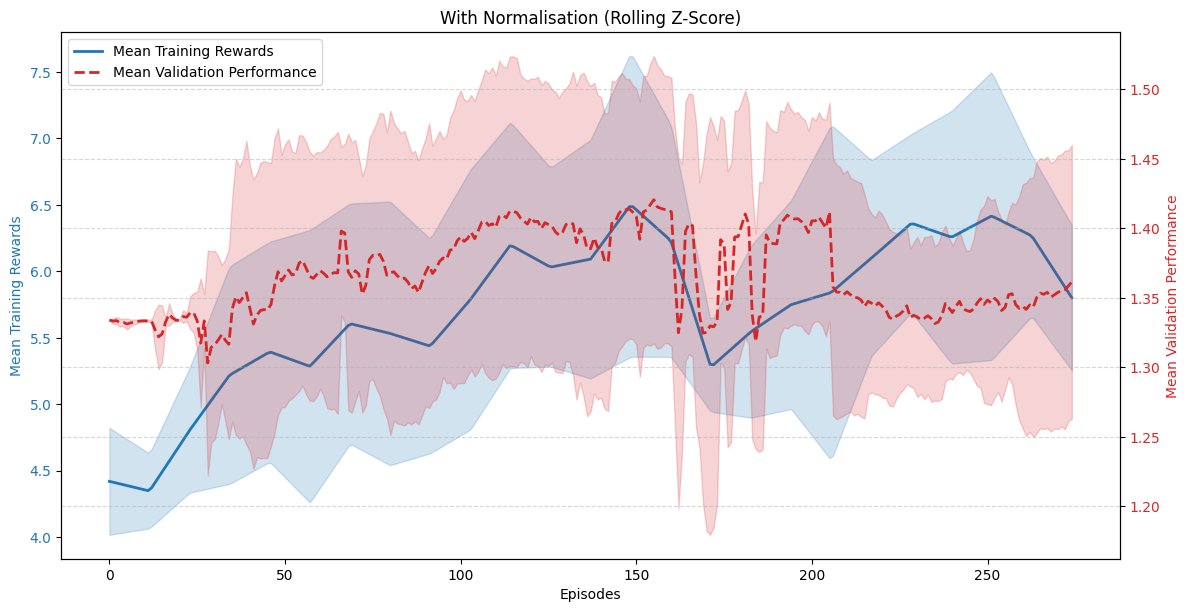

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_performance(folderPath, title="Mean Training Rewards & Validation Performance Over Training Period", saveFile=None):
    """
    Reads data from numbered subdirectories under folderPath, computes the mean and standard deviation
    across the runs for training rewards and validation performances, and plots the result.
    
    Parameters:
    - folderPath (str): The path to the folder containing numbered subdirectories for each run.
    - title (str): Plot title.
    - saveFile (str or None): If provided, the figure is saved to this file.
    
    Returns:
    - fig (matplotlib.figure.Figure): The created figure.
    """
    # Initialize containers.
    trainingRewardsAll = []
    validationPerformancesAll = []
    trainingRewardsStdAll = []
    validationPerformancesStdAll = []
    
    numDirectories = 0
    
    # Iterate through numeral directories in folderPath.
    for number in os.listdir(folderPath):
        numberDir = os.path.join(folderPath, number)
        if os.path.isdir(numberDir):
            trainingRewardsPath = os.path.join(numberDir, 'trainingRewards.txt')
            validationPerformancesPath = os.path.join(numberDir, 'validationPerformances.txt')
            
            if os.path.exists(trainingRewardsPath) and os.path.exists(validationPerformancesPath):
                trainingRewards = np.loadtxt(trainingRewardsPath)
                validationPerformances = np.loadtxt(validationPerformancesPath)
                
                # Initialize on the first valid directory.
                if numDirectories == 0:
                    trainingRewardsAll = np.zeros_like(trainingRewards)
                    validationPerformancesAll = np.zeros_like(validationPerformances)
                    trainingRewardsStdAll = []
                    validationPerformancesStdAll = []
                
                # Sum values element-wise.
                trainingRewardsAll += trainingRewards
                validationPerformancesAll += validationPerformances
                
                # Store arrays for std computation.
                trainingRewardsStdAll.append(trainingRewards)
                validationPerformancesStdAll.append(validationPerformances)
                
                numDirectories += 1
            else:
                print(f"Skipping directory {numberDir} as it does not contain the required files.")

    # Compute means.
    trainingRewardsMean = trainingRewardsAll / numDirectories
    validationPerformancesMean = validationPerformancesAll / numDirectories

    # Compute standard deviations.
    trainingRewardsStd = np.std(trainingRewardsStdAll, axis=0)
    validationPerformancesStd = np.std(validationPerformancesStdAll, axis=0)

    # Rescale Training Rewards if lengths differ.
    validationLength = len(validationPerformancesMean)
    trainingLength = len(trainingRewardsMean)
    if trainingLength < validationLength:
        xOld = np.linspace(0, 1, trainingLength)
        xNew = np.linspace(0, 1, validationLength)
        trainingRewardsMean = np.interp(xNew, xOld, trainingRewardsMean)
        trainingRewardsStd = np.interp(xNew, xOld, trainingRewardsStd)

    # Plotting.
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    color = 'tab:blue'
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Mean Training Rewards", color=color)
    line1 = ax1.plot(trainingRewardsMean, color=color, label="Mean Training Rewards", linewidth=2)
    ax1.fill_between(range(len(trainingRewardsMean)), 
                     trainingRewardsMean - trainingRewardsStd, 
                     trainingRewardsMean + trainingRewardsStd, 
                     color=color, alpha=0.2)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Secondary axis for validation performance.
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel("Mean Validation Performance", color=color)
    line2 = ax2.plot(validationPerformancesMean, color=color, label="Mean Validation Performance", 
                     linewidth=2, linestyle="dashed")
    ax2.fill_between(range(len(validationPerformancesMean)), 
                     validationPerformancesMean - validationPerformancesStd, 
                     validationPerformancesMean + validationPerformancesStd, 
                     color=color, alpha=0.2)
    ax2.tick_params(axis='y', labelcolor=color)

    # Combine legends from both axes.
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', fontsize=10)

    fig.tight_layout()
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    if saveFile:
        plt.savefig(saveFile)
    plt.show()
    return fig

# Plot for the Normalisation folder.
normalisationFolder = "portfolios/Normalisation/"
figure = plot_mean_performance(normalisationFolder, title="With Normalisation (Rolling Z-Score)", saveFile="plots/NormalisationEffect.png")

### 4.3.0 Example effect of noise on Prices

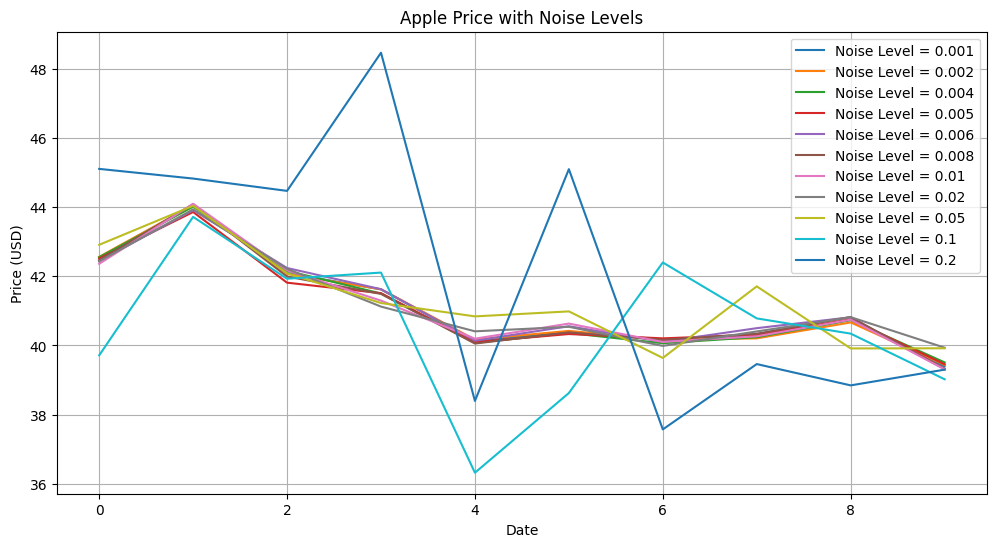

In [17]:
noises = [1e-3, 2e-3, 4e-3, 5e-3, 6e-3, 8e-3, 1e-2, 0.02, 0.05, 0.1, 0.2] #Do 0.2 if you want - barely visible.

PLOT_NOISE_EFFECT = True
horizon = 10 #time horizon to visualize over

def plotNoiseEffect():
    """
    Plot the Apple stock prices from the testing data.
    """
    plt.figure(figsize=(12, 6))
    for nVal in noises:
        testData = TESTING_DATA["AAPL"].copy()
        noise = np.random.normal(0, nVal, size=testData.shape)
        frame = testData + (noise * testData.std().values)
        closingPrices = frame["Close"].values
        plt.plot(closingPrices[:max(min(horizon, len(closingPrices)), 2)], label=f"Noise Level = {nVal}")
    
    plt.title('Apple Price with Noise Levels')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

if PLOT_NOISE_EFFECT:
    """
    Plot the noise effect on the Apple stock prices.
    """
    plotNoiseEffect()

### 4.3.1. Noise Analysis

In [18]:
import os
import numpy as np
import wandb

"""
WE DECIDED TO NORMALISE. REMEMBER THIS!!!!!
"""
NORMALIZE_DATA = True  


noises = [0, 1e-3, 2e-3, 4e-3, 5e-3, 6e-3, 8e-3, 1e-2, 0.02, 0.05]
portVals = dict()

# Folder paths
noiseFolder = f"portfolios/noises/{'Normalisation' if NORMALIZE_DATA else 'NonNormalisation'}/"
nonNormFolder = f"portfolios/{'Normalisation' if NORMALIZE_DATA else 'NonNormalisation'}/"

# Create the base directories if they don't exist
if not os.path.exists(noiseFolder):
    os.makedirs(noiseFolder)
if not os.path.exists(nonNormFolder):
    os.makedirs(nonNormFolder)

OLD_EPOCHS = 25  # approx 200k timesteps
NOISETESTING = True  # Set to True to test noise perturbations on the training data

if NOISETESTING:
    # Uses default hyperparameters to sweep over different noise values 
    # and see where training is problematic.
    EPOCHS = OLD_EPOCHS
    for s in VARIED_BASE_SEEDS:
        BASE_SEED = s
        for noise in noises:
            phase = "noise_testing"
            cfg = getConfig(phase)
            seed(BASE_SEED)  # Seed agent initialization
            wandb.init(
                project=PROJECT_NAME,
                config=cfg,
                name=f"exp-{phase}-{noise}_"
                     + ("_NO_" if not SCALE_LOG_REWARD else "") + "SCALING"
                     + ("_NORM" if NORMALIZE_DATA else "") + "BASE_SEED_" + str(BASE_SEED),
                reinit=True,
                group=cfg["group"],
                mode="online"
            )
            config = wandb.config

            agent = generateAgent(config)

            if wandb.run is not None:
                wandb.watch(agent.actor, log="all")
                wandb.watch(agent.critic, log="all")
                wandb.watch(agent.featureExtractor, log="all")

            print("*" * 50)
            print("Testing Noise: ", noise)
            PERTURBATION_NOISE = noise
            portVals[noise] = trainingLoop(agent, useNoiseEval=False, save=False)
            
            # Save to the noise folder
            folderForSavingNoise = f"{noiseFolder}{s}/"
            if not os.path.exists(folderForSavingNoise):
                os.makedirs(folderForSavingNoise)
            np.savetxt(f"{folderForSavingNoise}{noise}.txt", portVals[noise]["validation_performances"], fmt='%f')
            
            # If noise is zero, also save to the non-normalisation folder
            if noise == 0:
                folderForSavingNormOrNonNorm = f"{nonNormFolder}{s}/"
                if not os.path.exists(folderForSavingNormOrNonNorm):
                    os.makedirs(folderForSavingNormOrNonNorm)
                np.savetxt(f"{folderForSavingNormOrNonNorm}validationPerformances.txt", portVals[noise]["validation_performances"], fmt='%f')
                np.savetxt(f"{folderForSavingNormOrNonNorm}trainingRewards.txt", portVals[noise]["epoch_reward"], fmt='%f')
            print("*" * 50)
            wandb.finish()

EPOCHS = 25  # Set EPOCHS back or use best performing value as needed.

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


**************************************************
Testing Noise:  0
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.10311641799899479
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.21480633810109134
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3307922798249112
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.33064206376006866
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.4575877308809302
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.333803720728727
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.6117578402574828
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.4334125351589546
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.25110025477369247
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.5054274829213612
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.38924388966145296
Epoch: 1
1 Epochs takes: 238.42 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4751898319413874
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.22856610957890977
Episode: 2 Strategy: PPOLSTM
Episode Reward:

**************************************************
Testing Noise:  0.001
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.10239975582974538
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.21727892799758408
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3165700475400607
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.32818007018411244
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.45718218112064757
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.3340963594330506
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.6114557292658738
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.42976628105659787
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.2508202149517911
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.49832273061457855
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.39154105025702757
Epoch: 1
1 Epochs takes: 269.76 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4750686141600418
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.22626206765352425
Episode: 2 Strategy: PPOLSTM
Episode 

**************************************************
Testing Noise:  0.002
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.10182399210709776
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.21921129802005157
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.32893933053708174
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3241149506466213
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.45642452097907094
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.33486369312297937
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.611730220942408
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.425377366437913
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.250211468940726
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.49172754863828416
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3945245666767194
Epoch: 1
1 Epochs takes: 214.78 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.47656283836031543
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.22435706519169862
Episode: 2 Strategy: PPOLSTM
Episode Rew

**************************************************
Testing Noise:  0.004
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.10102936008769392
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.22315287758086277
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.33554263902854675
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.315205270309191
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.45291953717838285
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.33575124252060484
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.609577272571324
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.4171497161382174
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.250529750690919
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.47904333153487233
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.40019090490629816
Epoch: 1
1 Epochs takes: 223.44 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.47928625506347344
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.22034454145957172
Episode: 2 Strategy: PPOLSTM
Episode Re

**************************************************
Testing Noise:  0.005
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.10083887549492311
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.22433952758304565
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.33950179045919693
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.4952303534283927
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.43359110109211874
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.3537798295102932
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.5690375997796222
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.5162745394752912
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.2740939341520954
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4986782184299816
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.4856322599767249
Epoch: 1
1 Epochs takes: 195.63 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.5701850880608497
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.3796364551765442
Episode: 2 Strategy: PPOLSTM
Episode Rewa

**************************************************
Testing Noise:  0.006
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.1007976166441325
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.22686729915092047
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.33615644218113583
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.4682642178970219
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5784348933485424
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.4251530056460282
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.5600333117703471
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.4722115310682393
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.2492076528717755
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.46159120352587957
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.41385808530570234
Epoch: 1
1 Epochs takes: 205.34 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.47151434134912623
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.21170280030723004
Episode: 2 Strategy: PPOLSTM
Episode Re

**************************************************
Testing Noise:  0.008
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.10094813169498221
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.2332274452379344
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.32595725503425504
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.47675328470280987
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5783142382079429
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.3964763214402198
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.5621235381829179
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.4427094067555184
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.25018121162244444
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.44992853679444433
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.41975222788249456
Epoch: 1
1 Epochs takes: 186.53 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.46027122860844477
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.19712151779407944
Episode: 2 Strategy: PPOLSTM
Episode 

**************************************************
Testing Noise:  0.01
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.10166826279001172
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.239259727552681
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3249277447050898
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.4348315627464716
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.6148550481409201
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.41016445693944426
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.5940479202034514
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.45798340613625665
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.2979196896880336
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.42929410686155123
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.5055370662407057
Epoch: 1
1 Epochs takes: 218.15 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4354320394948759
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.12198700336753071
Episode: 2 Strategy: PPOLSTM
Episode Rewar

**************************************************
Testing Noise:  0.02
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.11234511851498687
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.28052421255808296
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3281490817899753
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.43597194117227744
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.6441572974867507
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.4720945876002951
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.5989069356607066
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.3699242291999063
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.31815943602672103
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4313210591541692
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.583117503465489
Epoch: 1
1 Epochs takes: 200.06 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.45407222146837645
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.21552096806446563
Episode: 2 Strategy: PPOLSTM
Episode Rewa

**************************************************
Testing Noise:  0.05
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.21871076797598665
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.5087224238263092
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.44842205211010455
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.5395910641320509
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.7754047279868592
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6168253291232904
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.7160619133234989
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.45502796692414993
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.4696520236522721
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.3486195990498686
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.7514135653952128
Epoch: 1
1 Epochs takes: 201.35 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.49331411498400346
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.2526328655100738
Episode: 2 Strategy: PPOLSTM
Episode Rewar

**************************************************
Testing Noise:  0
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.2802507595683333
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.20341650554215363
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.35829351518345226
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.4062635840787242
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.4540659014186956
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.648703230057526
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.3634969624536182
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2750610074629276
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.3938776443069769
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.23901944928255148
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3641657537077214
Epoch: 1
1 Epochs takes: 197.69 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.3150018776034928
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4377455536090798
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.

**************************************************
Testing Noise:  0.001
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.2823031652771769
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.21062034318130746
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.35824484154287556
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.36470391024431226
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.4654038555449336
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6522885615328253
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.3713076898040404
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.27741526497365543
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.3951032283391154
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.23521716397708303
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3641392923324789
Epoch: 1
1 Epochs takes: 205.65 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.31396021887883435
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.43935480842575897
Episode: 2 Strategy: PPOLSTM
Episode R

**************************************************
Testing Noise:  0.002
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.28450611439581464
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.2180865924440507
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3583210317557629
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3940799403187567
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.46571992690506625
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6465557997198867
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.377990001438528
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2835607684592838
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.3967040886055826
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.23129713566341126
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.36428339426185996
Epoch: 1
1 Epochs takes: 199.88 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.31303106075211773
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.44119792581897255
Episode: 2 Strategy: PPOLSTM
Episode Rew

**************************************************
Testing Noise:  0.004
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.28926539728887435
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.2334948952115844
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.35934059729257584
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.33130404029189797
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.4687318078895899
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6503475406220509
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.3921033918670114
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2876844053725547
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.40053487564496537
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.2244434734084244
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3652287731427051
Epoch: 1
1 Epochs takes: 198.44 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.3115626401267053
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4451372912860111
Episode: 2 Strategy: PPOLSTM
Episode Rewa

**************************************************
Testing Noise:  0.005
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.29182419470649296
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.24157142365710288
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.35953160933515715
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.33450339184630984
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.4691538118918752
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6482587700078477
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.3982137071580203
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2899901773747251
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.4022500948739225
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.22115389323475698
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3658930982865529
Epoch: 1
1 Epochs takes: 202.31 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.3109256988505793
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.44804336126909694
Episode: 2 Strategy: PPOLSTM
Episode Re

**************************************************
Testing Noise:  0.006
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.294509032472069
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.24983036296865474
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.36046151848375185
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3346827651585197
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.4598704124326669
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6504995009728671
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.40593393474482165
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2941794113928031
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.4044581229351647
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.21818949452598346
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.36662824400794003
Epoch: 1
1 Epochs takes: 201.94 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.31067629904680827
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4510492469376569
Episode: 2 Strategy: PPOLSTM
Episode Rew

**************************************************
Testing Noise:  0.008
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.30028233639494945
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.2670155679046952
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.36271006096402403
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3612412895690641
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.47685433688974777
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6545682897031029
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.41937281198640797
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2996911452877158
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.4084663519721139
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.21165392779425574
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3683631812394603
Epoch: 1
1 Epochs takes: 194.65 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.30985157468235425
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4565361385755933
Episode: 2 Strategy: PPOLSTM
Episode Re

**************************************************
Testing Noise:  0.01
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.30649748008881567
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.28496661337441404
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3654252611384279
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.4243908800762227
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.33801175640908854
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6727186527885276
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.42064972965016256
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.3063498738373589
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.41343075358769843
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.20582293381665595
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3709248903851532
Epoch: 1
1 Epochs takes: 222.28 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.3108512593375022
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.46354113935733104
Episode: 2 Strategy: PPOLSTM
Episode Re

**************************************************
Testing Noise:  0.02
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.34515888662405336
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.38851687773078947
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3925616418909852
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.416224489089168
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5066442093726684
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6718220714182777
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.5186990457873168
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.3485679121750578
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.4394553688408309
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.18296417276689425
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.38884007966771605
Epoch: 1
1 Epochs takes: 193.40 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.31768362378721815
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.5105189110072753
Episode: 2 Strategy: PPOLSTM
Episode Rewar

**************************************************
Testing Noise:  0.05
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.5369940261735906
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.8421034165700501
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.6013139870940623
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.6173501244721242
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.7636748116878311
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.8744176578254788
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.8516870054572445
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.5247206290916901
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5671420872825035
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.16955050802085125
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.5062527272549193
Epoch: 1
1 Epochs takes: 192.28 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4139542530863137
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.7860716970668604
Episode: 2 Strategy: PPOLSTM
Episode Reward: 

**************************************************
Testing Noise:  0
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.34148116600575895
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.23925936156777883
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.4755718511874003
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3448558528417991
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5414832383284915
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6083966549146127
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.46211959440451267
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.27810131499670065
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5612187763869412
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4390846076269024
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.387153863471692
Epoch: 1
1 Epochs takes: 206.84 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.23697491101012397
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.012435105076352843
Episode: 2 Strategy: PPOLSTM
Episode Reward

**************************************************
Testing Noise:  0.001
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.34443371721286065
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.2350319719437347
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.47024446158413913
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.34713724397804846
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5444637709942346
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6047229302575705
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.46108385545812736
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.27611247165361563
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5645634984787025
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.43700936245851585
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3936580082384529
Epoch: 1
1 Epochs takes: 206.02 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.23669958812348765
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.014743899829888357
Episode: 2 Strategy: PPOLSTM
Episode

**************************************************
Testing Noise:  0.002
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.34738986275441663
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.23109463434618716
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.46512040661939213
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3499412098835988
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5479778638607076
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6011916874088576
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.46027795641513025
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.274190623168991
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5681916945441174
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.43524340755588087
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.4003870802582936
Epoch: 1
1 Epochs takes: 199.52 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.23658251917145418
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.01691922211520891
Episode: 2 Strategy: PPOLSTM
Episode Re

**************************************************
Testing Noise:  0.004
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.3537413168622287
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.22354465472730461
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.4554935462440284
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.35578548722569514
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5554231111835264
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.5948265304795466
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4583981316925323
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2707681008718166
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5751712212424991
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4315381481799223
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.414027371329043
Epoch: 1
1 Epochs takes: 220.46 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.23667567882411372
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.022587461072422876
Episode: 2 Strategy: PPOLSTM
Episode Rewa

**************************************************
Testing Noise:  0.005
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.3570317143204272
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.21992646431717383
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.4506691282497286
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.35880592238076825
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5595658161244732
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.5915411147454992
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.45786992598876175
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2688584952551172
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5790732212018059
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4295434559761042
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.4209205716070734
Epoch: 1
1 Epochs takes: 200.30 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.23701799390019607
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.025599325632317982
Episode: 2 Strategy: PPOLSTM
Episode Re

**************************************************
Testing Noise:  0.006
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.3606976041461572
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.21670627119632707
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.4462595860663948
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3623418312488349
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5639434751788135
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.5891274586131863
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4570063370823618
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2677762559703951
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5769475496045664
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.42821562640933486
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.42800526859362087
Epoch: 1
1 Epochs takes: 204.63 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.2374452653434424
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.0288118166729579
Episode: 2 Strategy: PPOLSTM
Episode Rewar

**************************************************
Testing Noise:  0.008
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.3682113086143569
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.21046019452792075
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.43812557094108595
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.37004822946213833
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5732624143681344
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.5842165953442136
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.45639243730745926
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2649071613404188
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5848934256982674
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.42484967634214676
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.44277233416106565
Epoch: 1
1 Epochs takes: 207.12 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.2390725323715612
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.03578318981919906
Episode: 2 Strategy: PPOLSTM
Episode R

**************************************************
Testing Noise:  0.01
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.37634058180387403
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.204731562262585
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.430548321656798
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.37842605177226885
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5832603916856318
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.5797879295041881
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4565651206921273
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.26201658234732417
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5983321688140713
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4222436330111168
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.45750890817568823
Epoch: 1
1 Epochs takes: 203.40 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.2407434915236851
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.04464677870181247
Episode: 2 Strategy: PPOLSTM
Episode Reward

**************************************************
Testing Noise:  0.02
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.42710121865710315
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.18527424701087525
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.4049455728587631
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.43601642206858227
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.6499839265652076
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.5693930278098054
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.46254658203657995
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.25281050758289014
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.6415010947722535
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4154181986574139
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.539923870018038
Epoch: 1
1 Epochs takes: 206.35 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.2578391925579398
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.09355758400520381
Episode: 2 Strategy: PPOLSTM
Episode Rewa

**************************************************
Testing Noise:  0.05
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.6737909457283437
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.22685676214545414
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.4452810633975396
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.7573131321687245
Episode: 4 Strategy: PPOLSTM
Episode Reward: 1.009290906443625
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6665370579224326
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.5627795550178392
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2878197303699439
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.8215435661013988
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.44617126109814986
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.8552509360904814
Epoch: 1
1 Epochs takes: 201.48 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.3790734968036767
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.3626638522690115
Episode: 2 Strategy: PPOLSTM
Episode Reward: 

**************************************************
Testing Noise:  0
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4611665547260545
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.42657156711516886
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.4001243991606639
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3459305774846628
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5815806579514631
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6871322493928504
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.43765511493882414
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2931589007787627
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.4554928701427201
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.3815171780050681
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.5350111582185058
Epoch: 1
1 Epochs takes: 206.77 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.2366386283398925
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.3999173379346411
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.

**************************************************
Testing Noise:  0.001
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.45785803919563484
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4234950708923668
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3956243988520911
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.34649527319605866
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5882806870295947
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6904519973030472
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.44672576660198215
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.28763511293600574
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.4556135301046038
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.3776821668216508
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.5309644290160573
Epoch: 1
1 Epochs takes: 201.99 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.23271178747753624
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4063517012862686
Episode: 2 Strategy: PPOLSTM
Episode Rew

**************************************************
Testing Noise:  0.002
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4545067654019768
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.42020971928451484
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3931900779303965
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3472016918924101
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.5952787080855297
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.6962123529318256
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.44455514284288045
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.283458335660304
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.46135829688602925
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.3760558623775605
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.5261252489692572
Epoch: 1
1 Epochs takes: 255.77 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.2315486526496449
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4154786511520919
Episode: 2 Strategy: PPOLSTM
Episode Reward

**************************************************
Testing Noise:  0.004
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.44811269286507477
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4133375429067336
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3879941910918274
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.34999147285717847
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.6100403145834508
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.7022924440352818
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.41850872619721
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2836429597759036
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.47443092213890736
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.3759975591415232
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.52349782610258
Epoch: 1
1 Epochs takes: 209.09 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.22858368897886616
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.43405356204095513
Episode: 2 Strategy: PPOLSTM
Episode Reward:

**************************************************
Testing Noise:  0.005
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.44511244903888847
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4103355892432923
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3841454135695255
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3514152534182977
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.6176905766288752
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.7075790867088174
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.3617295907195004
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.3781819335422707
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5152196750768283
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.6363941878659771
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.6035159727933701
Epoch: 1
1 Epochs takes: 207.58 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.19122844125917335
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.5645319548896239
Episode: 2 Strategy: PPOLSTM
Episode Reward

**************************************************
Testing Noise:  0.006
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4422024143446138
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.40788698352699804
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.38247028217558865
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.35346604206347365
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.6258865488489382
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.7098458343072953
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.3765051501342156
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.27410852083243675
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.48175764573688573
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.37924805937482553
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.5173332170863167
Epoch: 1
1 Epochs takes: 247.40 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.2219482812423791
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4508806115562277
Episode: 2 Strategy: PPOLSTM
Episode Re

**************************************************
Testing Noise:  0.008
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4368074652455708
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.40301651684450324
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3791496745308053
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.35798902715340164
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.6425884246621625
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.7175919283191354
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4190227148582113
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.27980214819157645
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5531198168227962
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.49162622305713555
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.523234490735665
Epoch: 1
1 Epochs takes: 226.07 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.2226471317625673
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.49237787191133053
Episode: 2 Strategy: PPOLSTM
Episode Rewa

**************************************************
Testing Noise:  0.01
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.43187958230431284
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.39835223071012266
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.3770683311552445
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3635798567534889
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.6598441147099621
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.7296972053456945
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4588489725564764
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.27232048634629136
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.49309963963778936
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.3664137383349564
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.5049695931291636
Epoch: 1
1 Epochs takes: 202.74 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.21901771729337324
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.49731240880576477
Episode: 2 Strategy: PPOLSTM
Episode Rew

**************************************************
Testing Noise:  0.02
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4144412594630273
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.3841234762568962
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.37796336140238207
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.4072678263752867
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.7614721778459976
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.7907100047609541
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4650148434431416
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.2620474974809994
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5342983286963605
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.3617740345698497
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.4848975604524792
Epoch: 1
1 Epochs takes: 219.89 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.21207361501998506
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.6226038273009726
Episode: 2 Strategy: PPOLSTM
Episode Reward:

**************************************************
Testing Noise:  0.05
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4338579606486079
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.5672168476206663
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.7631275829647928
Episode: 3 Strategy: PPOLSTM
Episode Reward: 1.0714635156732206
Episode: 4 Strategy: PPOLSTM
Episode Reward: 1.053588639569658
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.8591662494045096
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.7508392288247316
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.366991109299291
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.687601858579618
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.5321466632432088
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.5821657102111768
Epoch: 1
1 Epochs takes: 206.17 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.29373456743307613
Episode: 1 Strategy: PPOLSTM
Episode Reward: 1.2472231908285218
Episode: 2 Strategy: PPOLSTM
Episode Reward: 1.2

**************************************************
Testing Noise:  0
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4673983676458071
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.42075476698731074
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.4326332206505922
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3949124342585051
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.31008539346412056
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.39097724746749485
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4835086107617306
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.3132068803984822
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.3832441236840549
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4740966214395508
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.390798975856284
Epoch: 1
1 Epochs takes: 243.33 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.12976355350112306
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.35606861847652976
Episode: 2 Strategy: PPOLSTM
Episode Reward: 

**************************************************
Testing Noise:  0.001
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.46986904815332275
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4208688124743811
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.438011076790245
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.38665869451436774
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.313226803667245
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.3885522623548585
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.48844122918294364
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.31234401129027756
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.3844500553968957
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.47195319577412853
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3872217468837338
Epoch: 1
1 Epochs takes: 233.22 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.13370140549747067
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.3574943813189543
Episode: 2 Strategy: PPOLSTM
Episode Rewa

**************************************************
Testing Noise:  0.002
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4724951823652402
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.42096065525997833
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.4442516346178732
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.37765399819397794
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.31611684540704066
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.3891861604762128
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.48759868219948066
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.31127738905819813
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.38639678178598214
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4687389377635336
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.384313069644973
Epoch: 1
1 Epochs takes: 237.81 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.1377156846539982
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.35950210153320283
Episode: 2 Strategy: PPOLSTM
Episode Re

**************************************************
Testing Noise:  0.004
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4780969245891284
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.4220753808442224
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.455444816957
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3623724869004843
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.3183462421544012
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.38034607873591453
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4762519840261277
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.3053150871852326
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.38998070055402945
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4617936485353433
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.37931849330108136
Epoch: 1
1 Epochs takes: 236.71 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.1454076121191914
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.3568603341638843
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0

**************************************************
Testing Noise:  0.005
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.48113292497494425
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.42278667911643847
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.46109146680144375
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.35569412430891156
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.3201209372243614
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.37869563847566257
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.47490299728195007
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.30426893010837075
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.39269899173117073
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4583047222393155
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3770319833625173
Epoch: 1
1 Epochs takes: 233.64 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.1495253432630238
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.35814531561195806
Episode: 2 Strategy: PPOLSTM
Episode

**************************************************
Testing Noise:  0.006
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4843541716208835
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.42378690551654913
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.46666203804412254
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3494436390266251
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.31918693453907254
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.37604885273443767
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4711920188872001
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.3023406418630117
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.3955130740283712
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4564762716647355
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.37582904538132933
Epoch: 1
1 Epochs takes: 230.18 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.15274341076491718
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.35725488505515113
Episode: 2 Strategy: PPOLSTM
Episode R

**************************************************
Testing Noise:  0.008
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4911958227074851
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.42630954654594977
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.47986769427064735
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.3371637833201877
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.3295040538753915
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.3729045133451012
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.46769039124685774
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.3001554454763564
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.40016615508070474
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.45122402433768816
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.37198868403177165
Epoch: 1
1 Epochs takes: 234.68 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.16160782096034826
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.3598808214698738
Episode: 2 Strategy: PPOLSTM
Episode R

**************************************************
Testing Noise:  0.01
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.498574119220791
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.42941689159328233
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.494816347987315
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.32547705488115786
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.33600395101884284
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.3710667379583916
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4660837878895161
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.29753201829339293
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.4052948983465656
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4475029231795391
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.3686886972214296
Epoch: 1
1 Epochs takes: 240.38 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.17161823519213487
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.36281561130417744
Episode: 2 Strategy: PPOLSTM
Episode Rewar

**************************************************
Testing Noise:  0.02
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.5447777677812864
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.45605697935126277
Episode: 2 Strategy: PPOLSTM
Episode Reward: 0.5841458433766875
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.28997605013764627
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.3762538256799661
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.3699254627504147
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.4659353922198646
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.291845096705003
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.4341242697954071
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.4302048822558677
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.36016213278786235
Epoch: 1
1 Epochs takes: 232.02 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.22704441921227214
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.3933671650328767
Episode: 2 Strategy: PPOLSTM
Episode Reward

**************************************************
Testing Noise:  0.05
Epoch: 0
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.7768822645601208
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.6526482985538269
Episode: 2 Strategy: PPOLSTM
Episode Reward: 1.0310978942036235
Episode: 3 Strategy: PPOLSTM
Episode Reward: 0.39798527354165625
Episode: 4 Strategy: PPOLSTM
Episode Reward: 0.6386312142635346
Episode: 5 Strategy: PPOLSTM
Episode Reward: 0.49391495714042044
Episode: 6 Strategy: PPOLSTM
Episode Reward: 0.5579050196786022
Episode: 7 Strategy: PPOLSTM
Episode Reward: 0.3273919705885824
Episode: 8 Strategy: PPOLSTM
Episode Reward: 0.5737497374035154
Episode: 9 Strategy: PPOLSTM
Episode Reward: 0.44026405504409816
Episode: 10 Strategy: PPOLSTM
Episode Reward: 0.4160050754535263
Epoch: 1
1 Epochs takes: 243.55 seconds
Episode: 0 Strategy: PPOLSTM
Episode Reward: 0.4765206378419524
Episode: 1 Strategy: PPOLSTM
Episode Reward: 0.6220558671092262
Episode: 2 Strategy: PPOLSTM
Episode Reward

#### **4.2.1.1 - Comparison With No Normalisation**

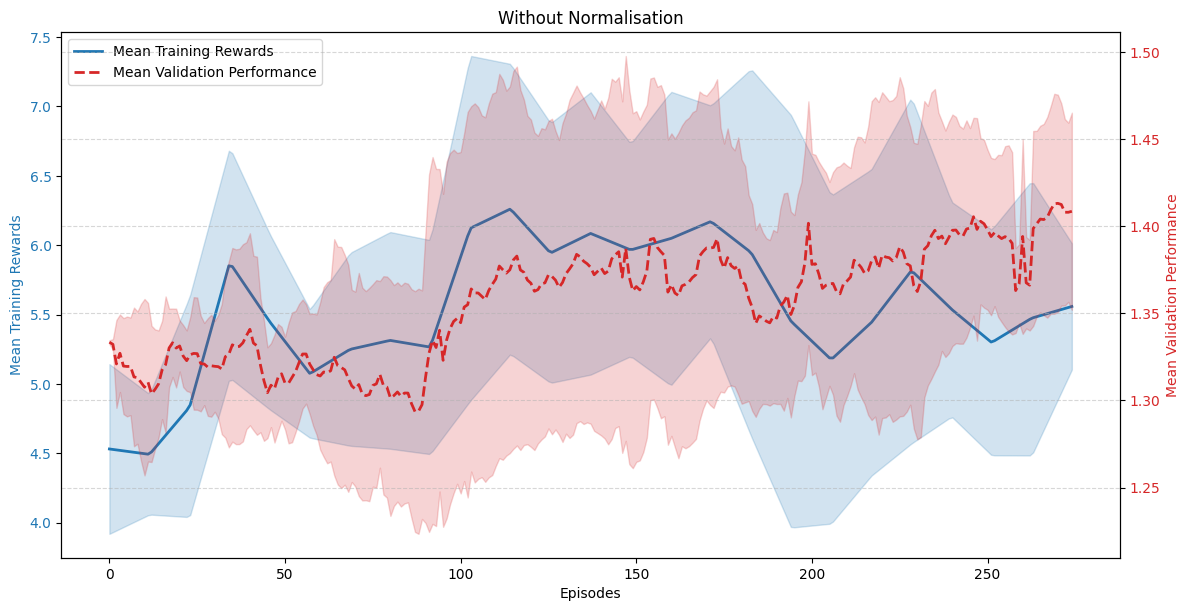

In [114]:

# Plot for the NonNormalisation folder.
nonNormalisationFolder = "portfolios/NonNormalisation/"
figure = plot_mean_performance(nonNormalisationFolder, title="Without Normalisation", saveFile="plots/NonNormalisationEffect.png")

In [32]:
def computeWeightedAUC(yValues, xValues=None, weightPower=1.0):
    """
    Computes a weighted Area Under Curve (AUC) for a learning curve. Helps to score noise levels
    """
    yValues = np.asarray(yValues)
    if xValues is None:
        xValues = np.arange(len(yValues))
    xValues = np.asarray(xValues)
    normTime = (xValues - xValues.min()) / (xValues.max() - xValues.min())
    weights = normTime ** weightPower
    weightedY = yValues * weights
    auc = np.trapezoid(weightedY, xValues)
    totalWeight = np.trapezoid(weights, xValues)
    normalizedAUC = auc / totalWeight if totalWeight > 0 else 0
    return normalizedAUC



σ=0: Weighted AUC (Normalized) = 36.73


Saved plot for σ=0.
σ=0.001: Weighted AUC (Normalized) = 36.92
Saved plot for σ=0.001.
σ=0.002: Weighted AUC (Normalized) = 31.37
Saved plot for σ=0.002.
σ=0.004: Weighted AUC (Normalized) = 35.80
Saved plot for σ=0.004.
σ=0.005: Weighted AUC (Normalized) = 36.23
Saved plot for σ=0.005.
σ=0.006: Weighted AUC (Normalized) = 38.36
Saved plot for σ=0.006.
σ=0.008: Weighted AUC (Normalized) = 35.12
Saved plot for σ=0.008.
σ=0.01: Weighted AUC (Normalized) = 40.09
Saved plot for σ=0.01.
σ=0.02: Weighted AUC (Normalized) = 36.23
Saved plot for σ=0.02.
σ=0.05: Weighted AUC (Normalized) = 36.06
Saved plot for σ=0.05.
Generally, the normalisation makes performance over the training period: 71.2 %) of the time better than the non-normalised data.
Should normalise =  True

--- Weighted AUC (Normalized) Summary ---
σ=0.010 -> AUC: 40.09
σ=0.006 -> AUC: 38.36
σ=0.001 -> AUC: 36.92
σ=0.000 -> AUC: 36.73
σ=0.005 -> AUC: 36.23
σ=0.020 -> AUC: 36.23
σ=0.050 -> AUC: 36.06
σ=0.004 -> AUC: 35.80
σ=0.008 -

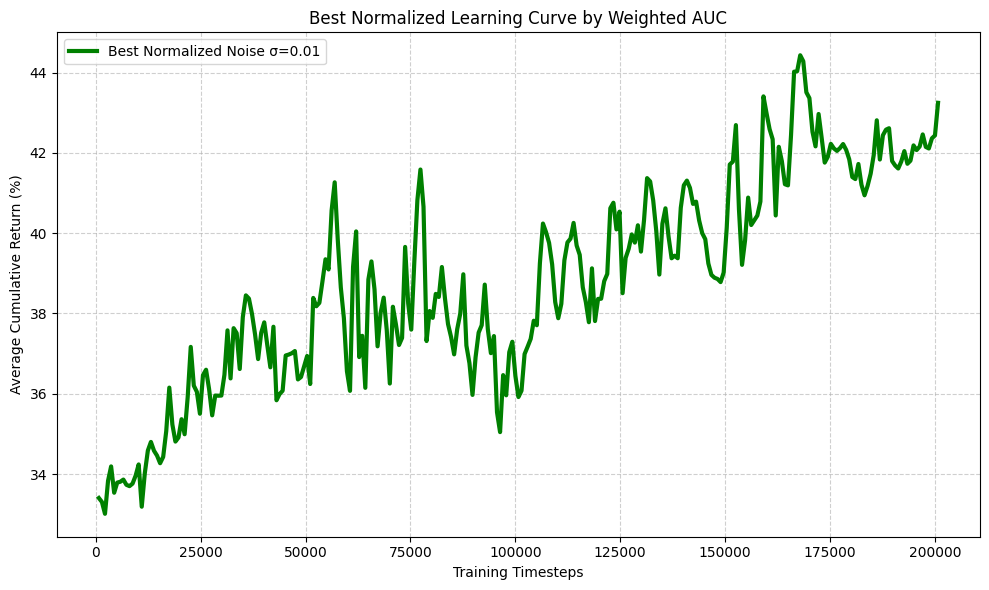

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os

WINDOW = 1
SHOW_STD = False  # Set to True to show shaded standard deviation

# Flattened list of all noise levels
noiseLevels = [0, 1e-3, 2e-3, 4e-3, 5e-3 , 6e-3, 8e-3, 1e-2 , 0.02, 0.05]

# Ensure plot directory exists
os.makedirs("plots", exist_ok=True)

def loadResults(baseDir, noiseLevel):
    """Load performance arrays for a noise level across all seeds."""
    allRuns = []
    for seed in VARIED_BASE_SEEDS:
        filePath = f"{baseDir}{seed}/{noiseLevel}.txt"
        if os.path.exists(filePath):
            data = np.loadtxt(filePath)
            processed = (data - 1) * 100
            allRuns.append(processed)
    return allRuns

def smooth(data, window):
    """Apply simple moving average."""
    if len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

def computeWeightedAUC(yValues, xValues=None, weightPower=1.0):
    yValues = np.asarray(yValues)
    if xValues is None:
        xValues = np.arange(len(yValues))
    xValues = np.asarray(xValues)
    normTime = (xValues - xValues.min()) / (xValues.max() - xValues.min())
    weights = normTime ** weightPower
    weightedY = yValues * weights
    auc = np.trapezoid(weightedY, xValues)
    totalWeight = np.trapezoid(weights, xValues)
    normalizedAUC = auc / totalWeight if totalWeight > 0 else 0
    return normalizedAUC

meanPercentageAboves = []
aucResults = []

# Variables to track best normalized curve
bestAuc = -np.inf
bestNoiseLevel = None
bestCurveX = None
bestCurveY = None

def plotNoiseComparison(noiseLevel):
    global bestAuc, bestNoiseLevel, bestCurveX, bestCurveY

    normFolder = "portfolios/noises/Normalisation/"
    nonNormFolder = "portfolios/noises/NonNormalisation/"

    normResults = loadResults(normFolder, noiseLevel)
    nonNormResults = loadResults(nonNormFolder, noiseLevel)

    if not normResults or not nonNormResults:
        print(f"Skipping σ={noiseLevel} — missing data.")
        return

    # Compute stats
    normMean = np.mean(normResults, axis=0)
    normStd = np.std(normResults, axis=0)
    nonNormMean = np.mean(nonNormResults, axis=0)
    nonNormStd = np.std(nonNormResults, axis=0)

    # Smooth
    normMeanSmooth = smooth(normMean, WINDOW)
    normStdSmooth = smooth(normStd, WINDOW)
    nonNormMeanSmooth = smooth(nonNormMean, WINDOW)
    nonNormStdSmooth = smooth(nonNormStd, WINDOW)

    percentageAbove = np.mean(normMeanSmooth > nonNormMeanSmooth) * 100
    meanPercentageAboves.append(percentageAbove)

    # Time axis
    xValues = np.linspace(WINDOW, EPOCHS * TRAINING_WINDOWS, len(normMeanSmooth)) * EPISODE_LENGTH

    # Compute weighted AUC for normalized only
    aucNorm = computeWeightedAUC(normMeanSmooth, xValues, weightPower=1.0)
    print(f"σ={noiseLevel}: Weighted AUC (Normalized) = {aucNorm:.2f}")
    aucResults.append((noiseLevel, aucNorm))

    # Track best normalized curve
    if aucNorm > bestAuc:
        bestAuc = aucNorm
        bestNoiseLevel = noiseLevel
        bestCurveX = xValues
        bestCurveY = normMeanSmooth

    # Plot comparison curves
    plt.figure(figsize=(10, 6))
    plt.plot(xValues, normMeanSmooth, label="Normalized", linewidth=2, color='blue')
    plt.plot(xValues, nonNormMeanSmooth, label="Non-Normalized", linewidth=2, color='orange')

    if SHOW_STD:
        plt.fill_between(xValues, normMeanSmooth - normStdSmooth, normMeanSmooth + normStdSmooth, color='blue', alpha=0.3)
        plt.fill_between(xValues, nonNormMeanSmooth - nonNormStdSmooth, nonNormMeanSmooth + nonNormStdSmooth, color='orange', alpha=0.3)

    plt.title(f"Noise Level σ={noiseLevel} Comparison")
    plt.xlabel("Training Timesteps")
    plt.ylabel("Average Cumulative Return (%)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/noiseComparison_sigma_{noiseLevel}.png")
    plt.close()
    print(f"Saved plot for σ={noiseLevel}.")

# ---- MAIN LOOP ----
for noise in noiseLevels:
    plotNoiseComparison(noise)

print(f"Generally, the normalisation makes performance over the training period: {round(np.mean(meanPercentageAboves), 2)} %) of the time better than the non-normalised data.")
print("Should normalise = ", np.mean(meanPercentageAboves) > 50)

# After plotting all noise levels
aucResults.sort(key=lambda x: x[1], reverse=True)
print("\n--- Weighted AUC (Normalized) Summary ---")
for sigma, auc in aucResults:
    print(f"σ={sigma:.3f} -> AUC: {auc:.2f}")

# Plot the best normalized curve by weighted AUC
if bestCurveX is not None and bestCurveY is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(bestCurveX, bestCurveY, label=f"Best Normalized Noise σ={bestNoiseLevel}", linewidth=3, color='green')
    plt.xlabel("Training Timesteps")
    plt.ylabel("Average Cumulative Return (%)")
    plt.title("Best Normalized Learning Curve by Weighted AUC")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


#### ~~4.4. Training Models~~

In [ ]:
def sweep():
    """
    Hyperparameter sweep function.

    For the active test defined in the TESTING dictionary, this function iterates over
    the corresponding hyperparameter values. For each value, it creates a configuration
    using getConfig (in the "hyperparameter_tuning" phase), generates an agent with generateAgent,
    and then calls trainingLoop with that agent and configuration.
    """
    # Map test types to their corresponding hyperparameter values and overrides.
    # For each override, if the value is None, then substitute the sweep value.
    sweep_params = {
        "RISK AVERSION": {
            "values": AGENT_RISK_AVERSIONS,
            "overrides": {"risk_aversion": None}
        },
        "LSTM OUTPUT SIZE": {
            "values": LSTMOUTPUTSIZES,
            "overrides": {"lstm_output_size": None}
        },
        "REWARD FUNCTION": {
            "values": REWARD_FUNCTIONS,
            "overrides": {"reward_function": None}
        },
        "LEARNING FREQUENCY": {
            "values": LEARNING_FREQUENCIES,
            "overrides": {"learning_frequency": None}
        },
        "LEARNING RATE": {
            "values": LEARNING_RATES,
            "overrides": {"learning_rate": None}
        }
    }
    phase = "hyperparameter_tuning"

    # Iterate over active test types defined in TESTING
    for testType, active in TESTING.items():
        if active and testType in sweep_params:
            param_info = sweep_params[testType]
            for value in param_info["values"]:
                print(f"Running sweep for {testType}: {value}")
                # Build the overrides dict, substituting sweep values where needed.
                overrides = {
                    key: (value if override is None else override)
                    for key, override in param_info["overrides"].items()
                }
                agentCfg = getConfig(phase, optionalHyperConfig=overrides)
                agent = generateAgent(agentCfg)

                wandb.init(project=PROJECT_NAME, config=agentCfg, name=f"exp-{phase}-{testType}-{value}", reinit=True)  
                config = wandb.config

                agent = generateAgent(config)

                if wandb.run is not None:
                    wandb.watch(agent.actor, log="all")
                    wandb.watch(agent.critic, log="all")
                    wandb.watch(agent.featureExtractor, log="all")

                trainingLoop(agent)
            break  # Run only one active test type per sweep


def hyperSweep():
    """
    Runs the hyperparameter sweep by sequentially activating one test type at a time.
    """
    for key in list(TESTING.keys()):
        print("=" * 50)
        TESTING[key] = True
        sweep()
        TESTING[key] = False
        print("=" * 50)


PERTURBATION_NOISE = 0  # temporary
EPOCHS = 3             
TRAIN = False           # Set to True to run the sweep

"""
NEEDS TO BE CHECKED TO ENSURE THE CONFIG IS CORRECT
"""

# Example usage:
if TRAIN:
    hyperSweep()

### 4.5. Evaluation

#### 4.5.0. Scoring Functions

In [ ]:
def maxDrawdown(arr):
    # Maximum Drawdown calculation
    maxValue = float("-inf")
    maxDrawdown = 0.0
    for value in arr:
        maxValue = max(maxValue, value)
        drawdown = (maxValue - value) / maxValue 
        maxDrawdown = max(maxDrawdown, drawdown)
    return maxDrawdown

#Scoring Formula
def scoreFormula(agentArray, averageRandomReturn):
    # score by (cumulative return - average random return)/max drawdown all times sharpe ratio
    cumulativeReturn = agentArray[-1] / START_CASH - 1
    maximumDrawdown = maxDrawdown(agentArray)
    percChange = np.diff(agentArray) / agentArray[:-1]
    sharpe = np.mean(percChange)/np.std(percChange) if np.std(percChange) != 0 else 0
    score = ((cumulativeReturn - averageRandomReturn) / maximumDrawdown) * sharpe
    metrics = {
        "Cumulative \nReturn (%)": cumulativeReturn * 100,
        "Maximum \nDrawdown (%)": maximumDrawdown * 100,
        "Sharpe Ratio": sharpe,
        "Score": score
    }
    return metrics


#### 4.5.1. Functions Called by 4.5.2

In [ ]:
NOISE_ITERATIONS_VALIDATION = 10

HYPERS = {
    "Risk Aversion" : AGENT_RISK_AVERSIONS,
    "LSTM Output Size" : LSTMOUTPUTSIZES,
    "Reward Function" : REWARD_FUNCTIONS,
    "Learning Frequency": LEARNING_FREQUENCIES, 
    "Learning Rate": LEARNING_RATES,
    }


def setParameters(parameter, hyper, riskAversion):
    """
    When Evaluating hyperparameters, this function is called to set the parameters of the agent.
    """
    rf = "Standard Logarithmic Returns"
    freq = int(EPISODE_LENGTH / 30)
    lr = 3e-4
    risk = parameter if hyper == "Risk Aversion" else riskAversion
    lstmOutputSize = 128
    if hyper == "Risk Aversion":
        agent = generateAgent(lstmOutputSize, parameter, lr, freq)
    elif hyper == "Learning Frequency":
        freq = parameter
        agent = generateAgent(lstmOutputSize, risk, lr, freq)
    elif hyper == "Reward Function":
        rf = parameter
        agent = generateAgent(lstmOutputSize, risk, lr, freq)
    elif hyper == "LSTM Output Size":
        agent = generateAgent(parameter, risk, lr, freq)
    elif hyper == "Learning Rate":
        lr = parameter
        agent = generateAgent(lstmOutputSize, risk, parameter, freq)
    return rf, freq, risk, agent, lr

def validationAgentsLoop(dataType, riskAversion, lr, noiseIteration, performances):
    """
    This just loops over every single hyperparameter and runs the evaluation function for each one.
    The performances dictionary stores the portfolio trajectory for each evaluation loop.
    """
    for hyper, param in HYPERS.items():
        TESTING[hyper.upper()] = True
        for epo in range(1, EPOCHS + 1):
            for parameter in param:
                saveFolder = f"save/{dataType}/{epo * TRAINING_WINDOWS}/{hyper}-{parameter}/"
                rf, freq, risk, agent, lr = setParameters(parameter, hyper, riskAversion)
                agent.load(saveFolder)
                portfolioValues = evaluateAgent(risk, rf, agent, freq, lr=lr, num=epo * TRAINING_WINDOWS, conf=None, save=False, epoch = noiseIteration) # ignore standard log - agent is not learning here
                performances[saveFolder].append(portfolioValues) 
        TESTING[hyper.upper()] = False

def testAgentsLoop(dataType, rewardFunctions, bestParams, performances):
    """
    This is a simpler loop that simply runs the evaluation function for each reward function.
    This is called later on to see how each checkpointed testing agent (saved at each epoch) performs on the test set.
    """
    for rewardFunc in rewardFunctions:
        TESTING["REWARD FUNCTION"] = True
        for epoch in range(1, EPOCHS + 1):
            saveFolder = f"save/{dataType}/{epoch*TRAINING_WINDOWS}/Reward Function-{rewardFunc}"
            # agent = PPOAgent( 
            #             state_n=bestParams["LSTM Output Size"], 
            #             actions_n=len(productIds) + 1,
            #             alpha=bestParams["Learning Rate"],
            #             policyClip = 0.2,
            #             gamma=0.99,
            #             lstmHiddenSize=LSTMHIDDENSIZE,
            #             actor_noise=0,
            #             batch_size=int(bestParams["Frequency"]),
            #             fc1_n=128,
            #             fc2_n=128,
            #             gaeLambda=0.98,
            #             epochs=1,
            #             riskAversion=None,#not required for the agent
            #             featureExtractor = LstmFeatureExtractor(NUMBER_OF_FEATURES, 128, bestParams["LSTM Output Size"]),
            #             maxSize=bestParams["Frequency"],
            #             nonFeatureStateDim = (TIME_WINDOW, NUMBER_OF_FEATURES),
            #                 )
            agent.load(saveFolder)
            portfolioValues = evaluateAgent("", rewardFunc, agent, "", "", epoch*TRAINING_WINDOWS, dataType=dataType, save=False, epoch=epoch, showTable = False)
            performances[saveFolder].append(portfolioValues) 
        TESTING["REWARD FUNCTION"] = False

def runSavedAgents(lstmOutputSize = 128, riskAversion=0, lr=3e-4, freq=int(EPISODE_LENGTH / 30), dataType = "validation", rewardFunctions = None, bestParams=None):
    performances = defaultdict(list)
    start = time.time()
    # Since noise is added only to the validation data, we don't need to run the test data for multiple iterations
    iters = NOISE_ITERATIONS_VALIDATION if dataType == "validation" else 1
    for noiseIteration in range(iters):
        # The number of validation iterations referred to earlier
        if noiseIteration > 0:
            print(f"{noiseIteration} Noise Iterations takes: {(time.time() - start):.2f} seconds")
        if dataType == "validation":
            validationAgentsLoop(dataType, riskAversion,  lr, noiseIteration, performances)
        else:
            testAgentsLoop(dataType, rewardFunctions, bestParams, performances)
    return performances
                
RUN_SAVED_TRAINED_AGENTS = False                

if RUN_SAVED_TRAINED_AGENTS:
    runSavedAgents()
        

#### 4.5.2.  Assess

In [ ]:
RANDOM_REPEATS = 1000

def runTestScoring(dataType, averageRandomReturn, performances, rewardFunc):
    """
    Essentially scores each final reward function model being tested.
    """
    table = [["Epoch/Model", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]]
    for epoch in range(1, EPOCHS + 1):
        key = f"save/{dataType}/{epoch*TRAINING_WINDOWS}/Reward Function-{rewardFunc}"
        portfolioNumbers = performances[key]
        portfolioNumbers = np.mean(np.array(portfolioNumbers), axis=0)
        metrics = scoreFormula(portfolioNumbers, averageRandomReturn)
        table.append([f"Epoch {epoch}"] + [round(met, 4) for met in metrics.values()])
    tabulate_neatly(table, headers="firstrow", title=f"Reward Function-{rewardFunc} | Scores and Metrics Tabulated (Test Set)")

def runValidationScoring(dataType, averageRandomReturn, performances, hyper=None, param=None):
    """
    Essentially scores each hyperparameter model being tested. This will take something like 30 minutes to run.
    It returns quite a few html tables, providing a score for every hyperparameter at each epoch it was trained at.
    """
    moreData = defaultdict(lambda: float("-inf"))
    epochNumber = defaultdict(lambda: 0)
    bestMetrics = {}  

    for epoch in range(1, EPOCHS + 1):
        table = [["Hyperparameter", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]]
        bestScore = float("-inf")
        bestParameter = None
        for parameter in param:
            key = f"save/{dataType}/{epoch * TRAINING_WINDOWS}/{hyper}-{parameter}/"
            portfolioNumbers = performances[key]
            portfolioNumbers = np.mean(np.array(portfolioNumbers), axis=0)
            metrics = scoreFormula(portfolioNumbers, averageRandomReturn)
            key = f"{hyper.title()}-{parameter}"
            if metrics["Score"] > moreData[key]:
                moreData[key] = metrics["Score"]
                epochNumber[key] = epoch
                bestMetrics[key] = metrics
            table.append([f"{hyper.title()}-{parameter}"] + [round(met, 4) for met in metrics.values()])
            if metrics["Score"] > bestScore:
                bestScore = metrics["Score"]
                bestParameter = f"{hyper.title()}-{parameter}"
        print(f"Epoch {epoch} | Best Hyperparameter: ", bestParameter)
        print(f"Epoch {epoch} | Best Score: ", bestScore)
        tabulate_neatly(table, headers="firstrow", title=f"Epoch: {epoch} | Scores and Metrics Tabulated")
    
    table2 = [["Hyperparameter", "Best Epoch", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]]
    for key in bestMetrics.keys():
        m = bestMetrics[key]
        table2.append([
            key,
            epochNumber[key],
            round(m["Cumulative \nReturn (%)"], 4),
            round(m["Maximum \nDrawdown (%)"], 4),
            round(m["Sharpe Ratio"], 4),
            round(m["Score"], 4)
        ])
    tabulate_neatly(table2, headers="firstrow", title=f"Best Hyperparameters with Detailed Metrics: {hyper.title()}")

def scoreAgents(dataType="validation", rewardFunctions=None, perfs = None, runAgents=True):
    """
    A higher level scoring function that calls eather runValidationScoring or runTestScoring depending on the dataType.
    It also runs the random agent as a benchmark for the what is being tested.
    The base seed for the random agent is only varied during testing. A limitation. However, this is consistent with 
    the methodology described in my report.
    """
    global BASE_SEED
    ORIGINAL_BASE_SEED = BASE_SEED
    averageRandomPerformance = []
    for bench in range(RANDOM_REPEATS):
        if dataType == "testing": # prior code bug. Last minute changes meant that I did not specify varying the random base seeed only for testing.
            if bench % (RANDOM_REPEATS // len(VARIED_BASE_SEEDS)) == 0 and VARIED_BASE_SEEDS:  
                BASE_SEED = VARIED_BASE_SEEDS.pop()
        randomArray = evaluateAgent("", "Standard Logarithmic Returns", "", "", lr="", num=0, conf=None, save=False, dataType=dataType, benchmark=True, epoch = bench) # added slr new (not necessary) error handling
        averageRandomPerformance.append(randomArray)
    averageRandomReturn = np.mean(np.array(averageRandomPerformance), axis=0)[-1] / START_CASH - 1
    forStd = np.std(np.array(averageRandomPerformance)[:, -1]) / START_CASH  
    print("RANDOM STD: ", forStd)
    averageRandomPerformance = np.mean(np.array(averageRandomPerformance), axis=0)
 
    # baseline
    metrics = scoreFormula(averageRandomPerformance, averageRandomReturn)
    table = [["Hyperparameter", "Cumulative \nReturn (%)", "Maximum \nDrawdown (%)", "Sharpe Ratio", "Score"]] 
    table.append(["RANDOM"] + [round(met, 4) for met in metrics.values()])
    tabulate_neatly(table, headers="firstrow", title=f"Random Agent")
    if runAgents:
        if dataType == "validation":
            performances = runSavedAgents(dataType=dataType)
            for hyper, param in HYPERS.items():
                runValidationScoring(dataType, averageRandomReturn, performances, hyper, param)
        else:
            for rewardFunc in rewardFunctions:
                performances = perfs
                runTestScoring(dataType, averageRandomReturn, perfs, rewardFunc)
    return [averageRandomReturn, averageRandomPerformance]



"""
DID YOU SEED YOUR RUNS CORRECTLY
"""
GENERATE_SCORES = False
if GENERATE_SCORES:
    scoreAgents()

RANDOM STD:  0.07099710751766847


Random Agent

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 RANDOM 21.1466 10.8581 0.0818 0

1 Noise Iterations takes: 149.98 seconds
2 Noise Iterations takes: 306.80 seconds
3 Noise Iterations takes: 451.34 seconds
4 Noise Iterations takes: 605.22 seconds
5 Noise Iterations takes: 763.21 seconds
6 Noise Iterations takes: 914.87 seconds
7 Noise Iterations takes: 1072.30 seconds
8 Noise Iterations takes: 1223.25 seconds
9 Noise Iterations takes: 1376.60 seconds
Epoch 1 | Best Hyperparameter:  Risk Aversion-0.25
Epoch 1 | Best Score:  0.23939683437714804


Epoch: 1 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Risk Aversion-0.25 42.427 10.4306 0.1173 0.2394 
 Risk Aversion-0.5 31.6932 10.5376 0.1015 0.1016 
 Risk Aversion-1.0 40.1599 9.6733 0.1214 0.2385 
 Risk Aversion-1.5 35.0447 10.9238 0.1154 0.1468 
 Risk Aversion-2.0 24.7197 10.5637 0.084 0.0284

Epoch 2 | Best Hyperparameter:  Risk Aversion-1.0
Epoch 2 | Best Score:  0.1999690617785063


Epoch: 2 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Risk Aversion-0.25 37.7202 8.9463 0.1077 0.1996 
 Risk Aversion-0.5 30.815 9.5647 0.1028 0.1039 
 Risk Aversion-1.0 36.8677 9.4365 0.12 0.2 
 Risk Aversion-1.5 36.6128 10.8834 0.1207 0.1716 
 Risk Aversion-2.0 20.7509 11.3032 0.0711 -0.0025

Epoch 3 | Best Hyperparameter:  Risk Aversion-1.5
Epoch 3 | Best Score:  0.20588395526800424


Epoch: 3 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Risk Aversion-0.25 37.4158 9.3614 0.1119 0.1944 
 Risk Aversion-0.5 30.6912 10.6204 0.0988 0.0888 
 Risk Aversion-1.0 37.4835 9.7713 0.1182 0.1976 
 Risk Aversion-1.5 39.219 11.2662 0.1283 0.2059 
 Risk Aversion-2.0 27.0292 10.9012 0.0892 0.0481

Best Hyperparameters with Detailed Metrics: Risk Aversion

Hyperparameter Best Epoch Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Risk Aversion-0.25 1 42.427 10.4306 0.1173 0.2394 
 Risk Aversion-0.5 2 30.815 9.5647 0.1028 0.1039 
 Risk Aversion-1.0 1 40.1599 9.6733 0.1214 0.2385 
 Risk Aversion-1.5 3 39.219 11.2662 0.1283 0.2059 
 Risk Aversion-2.0 3 27.0292 10.9012 0.0892 0.0481

Epoch 1 | Best Hyperparameter:  Lstm Output Size-32
Epoch 1 | Best Score:  0.3299992910254741


Epoch: 1 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Lstm Output Size-32 46.2262 10.8824 0.1432 0.33 
 Lstm Output Size-64 31.3296 11.5622 0.1038 0.0914 
 Lstm Output Size-128 49.2154 11.461 0.1291 0.3161 
 Lstm Output Size-256 43.408 12.2225 0.1233 0.2246 
 Lstm Output Size-512 40.286 13.4571 0.1184 0.1684

Epoch 2 | Best Hyperparameter:  Lstm Output Size-32
Epoch 2 | Best Score:  0.43319112357095146


Epoch: 2 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Lstm Output Size-32 50.3995 9.5552 0.1415 0.4332 
 Lstm Output Size-64 37.8728 10.3289 0.1051 0.1702 
 Lstm Output Size-128 47.087 13.1347 0.1239 0.2446 
 Lstm Output Size-256 35.1069 13.998 0.0983 0.098 
 Lstm Output Size-512 28.9808 11.8673 0.0974 0.0643

Epoch 3 | Best Hyperparameter:  Lstm Output Size-32
Epoch 3 | Best Score:  0.36988544754651237


Epoch: 3 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Lstm Output Size-32 47.212 10.0965 0.1433 0.3699 
 Lstm Output Size-64 47.8789 11.4596 0.1074 0.2505 
 Lstm Output Size-128 47.7532 12.8164 0.1284 0.2665 
 Lstm Output Size-256 37.7957 13.5373 0.1057 0.13 
 Lstm Output Size-512 31.4931 13.0951 0.1039 0.0821

Best Hyperparameters with Detailed Metrics: Lstm Output Size

Hyperparameter Best Epoch Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Lstm Output Size-32 2 50.3995 9.5552 0.1415 0.4332 
 Lstm Output Size-64 3 47.8789 11.4596 0.1074 0.2505 
 Lstm Output Size-128 1 49.2154 11.461 0.1291 0.3161 
 Lstm Output Size-256 1 43.408 12.2225 0.1233 0.2246 
 Lstm Output Size-512 1 40.286 13.4571 0.1184 0.1684

Epoch 1 | Best Hyperparameter:  Reward Function-Differential Sharpe Ratio_0.05
Epoch 1 | Best Score:  0.08470680077681966


Epoch: 1 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Reward Function-Differential Sharpe Ratio_0.01 22.2106 13.2847 0.0672 0.0054 
 Reward Function-Differential Sharpe Ratio_0.05 29.3137 10.4191 0.1081 0.0847 
 Reward Function-Differential Sharpe Ratio_0.1 29.2943 10.3891 0.108 0.0847

Epoch 2 | Best Hyperparameter:  Reward Function-Differential Sharpe Ratio_0.05
Epoch 2 | Best Score:  0.08483288033726324


Epoch: 2 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Reward Function-Differential Sharpe Ratio_0.01 20.3181 10.3421 0.0651 -0.0052 
 Reward Function-Differential Sharpe Ratio_0.05 29.326 10.4137 0.108 0.0848 
 Reward Function-Differential Sharpe Ratio_0.1 29.2724 10.391 0.1078 0.0843

Epoch 3 | Best Hyperparameter:  Reward Function-Differential Sharpe Ratio_0.05
Epoch 3 | Best Score:  0.08614330257090957


Epoch: 3 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Reward Function-Differential Sharpe Ratio_0.01 17.5693 9.1959 0.0631 -0.0245 
 Reward Function-Differential Sharpe Ratio_0.05 29.4124 10.3968 0.1084 0.0861 
 Reward Function-Differential Sharpe Ratio_0.1 25.7285 15.5987 0.0801 0.0235

Best Hyperparameters with Detailed Metrics: Reward Function

Hyperparameter Best Epoch Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Reward Function-Differential Sharpe Ratio_0.01 1 22.2106 13.2847 0.0672 0.0054 
 Reward Function-Differential Sharpe Ratio_0.05 3 29.4124 10.3968 0.1084 0.0861 
 Reward Function-Differential Sharpe Ratio_0.1 1 29.2943 10.3891 0.108 0.0847

Epoch 1 | Best Hyperparameter:  Learning Frequency-24
Epoch 1 | Best Score:  0.31610401943845884


Epoch: 1 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Learning Frequency-73 8.1483 16.7534 0.033 -0.0256 
 Learning Frequency-36 43.6583 11.5813 0.1075 0.2089 
 Learning Frequency-24 49.2154 11.461 0.1291 0.3161 
 Learning Frequency-18 32.4555 13.7826 0.0936 0.0768 
 Learning Frequency-14 28.338 9.8354 0.0864 0.0632

Epoch 2 | Best Hyperparameter:  Learning Frequency-24
Epoch 2 | Best Score:  0.24463648725657322


Epoch: 2 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Learning Frequency-73 10.6301 14.5806 0.0402 -0.029 
 Learning Frequency-36 40.5056 9.869 0.1118 0.2193 
 Learning Frequency-24 47.087 13.1347 0.1239 0.2446 
 Learning Frequency-18 34.5706 14.3083 0.0973 0.0913 
 Learning Frequency-14 31.6385 9.4229 0.1008 0.1122

Epoch 3 | Best Hyperparameter:  Learning Frequency-24
Epoch 3 | Best Score:  0.26654062450700794


Epoch: 3 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Learning Frequency-73 12.9021 13.7746 0.0475 -0.0284 
 Learning Frequency-36 39.1675 10.374 0.1109 0.1926 
 Learning Frequency-24 47.7532 12.8164 0.1284 0.2665 
 Learning Frequency-18 38.023 11.5963 0.1099 0.16 
 Learning Frequency-14 29.9057 9.56 0.0952 0.0873

Best Hyperparameters with Detailed Metrics: Learning Frequency

Hyperparameter Best Epoch Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Learning Frequency-73 1 8.1483 16.7534 0.033 -0.0256 
 Learning Frequency-36 2 40.5056 9.869 0.1118 0.2193 
 Learning Frequency-24 1 49.2154 11.461 0.1291 0.3161 
 Learning Frequency-18 3 38.023 11.5963 0.1099 0.16 
 Learning Frequency-14 2 31.6385 9.4229 0.1008 0.1122

Epoch 1 | Best Hyperparameter:  Learning Rate-0.0003
Epoch 1 | Best Score:  0.31610401943845884


Epoch: 1 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Learning Rate-0.0001 29.3534 10.4859 0.1078 0.0844 
 Learning Rate-0.0003 49.2154 11.461 0.1291 0.3161 
 Learning Rate-0.0005 36.1413 11.066 0.1237 0.1676 
 Learning Rate-0.0007 37.8811 9.7864 0.1006 0.1719

Epoch 2 | Best Hyperparameter:  Learning Rate-0.0003
Epoch 2 | Best Score:  0.24463648725657322


Epoch: 2 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Learning Rate-0.0001 18.3978 11.4616 0.0689 -0.0165 
 Learning Rate-0.0003 47.087 13.1347 0.1239 0.2446 
 Learning Rate-0.0005 39.2254 11.0959 0.1307 0.213 
 Learning Rate-0.0007 36.214 8.7047 0.1009 0.1747

Epoch 3 | Best Hyperparameter:  Learning Rate-0.0005
Epoch 3 | Best Score:  0.2790726201494906


Epoch: 3 | Scores and Metrics Tabulated

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Learning Rate-0.0001 3.8538 14.9503 0.0179 -0.0207 
 Learning Rate-0.0003 47.7532 12.8164 0.1284 0.2665 
 Learning Rate-0.0005 41.8279 10.4998 0.1417 0.2791 
 Learning Rate-0.0007 38.075 9.5516 0.1014 0.1798

Best Hyperparameters with Detailed Metrics: Learning Rate

Hyperparameter Best Epoch Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 Learning Rate-0.0001 1 29.3534 10.4859 0.1078 0.0844 
 Learning Rate-0.0003 1 49.2154 11.461 0.1291 0.3161 
 Learning Rate-0.0005 3 41.8279 10.4998 0.1417 0.2791 
 Learning Rate-0.0007 3 38.075 9.5516 0.1014 0.1798

## 5. Testing Process

### 5.1. Best Models (if any) Trained

In [ ]:
REWARDS = {
    "Reward": [
        "Standard Logarithmic Returns",
        "Differential Sharpe Ratio_0.01",
        "Differential Sharpe Ratio_0.05",
        "Differential Sharpe Ratio_0.1",
        "CVaR_0.25",
        "CVaR_0.5",
        "CVaR_1.0",
        "CVaR_1.5",
        "CVaR_2.0"
    ]
}

#this will actually test them too lol
def trainTestingAgents(phase="reward_testing"):
    TESTING["REWARD FUNCTION"] = True
    seed(BASE_SEED) # Seed agent initialization
    for rew in REWARDS["Reward"]:
        cfg = getConfig(phase)
        wandb.init(
                    project=PROJECT_NAME,
                    config=cfg,
                    name=f"exp-{phase}_"
                        + ("_NO_" if not SCALE_LOG_REWARD else "") + "SCALING"
                        + ("_NORM" if NORMALIZE_DATA else "") + "BASE_SEED_" + str(BASE_SEED),
                    reinit=True,
                    group=cfg["group"],
                    mode="online" 
                )
        config = wandb.config

        agent = generateAgent(config)

        if wandb.run is not None:
            wandb.watch(agent.actor, log="all")
            wandb.watch(agent.critic, log="all")
            wandb.watch(agent.featureExtractor, log="all")

        trainingLoop(
            ppoAgent = agent,
            conf = "Reward Function-" + rew + " | " + "Strategy-PPOLSTM",
            evalType = "testing"
        )
    TESTING["REWARD FUNCTION"] = False


TRAINING_WINDOWS = ((TRAINING_PERIODS + VALIDATION_PERIODS - EPISODE_LENGTH) // TIMESTEP_SHIFT) + 1
SUM_TRAINING_PERIODS = TRAINING_WINDOWS * EPOCHS * (EPISODE_LENGTH - TIME_WINDOW) # because first time window steps are not used to learn
LEARNING_CURVE_FREQUENCY = SUM_TRAINING_PERIODS // 100


RUN_FINAL = False
if RUN_FINAL:
    for base in VARIED_BASE_SEEDS:
        BASE_SEED = base #Vary the base seed for the reward tests.
        trainTestingAgents()
    


KeyboardInterrupt: 

### 5.2. Per-epoch performance Analysis

In [ ]:
"""
This will run the test agents on the test set and return the portfolio values for each agent.
It runs relatively quickly, less than a minute, since it is not training the agents, just running them on the test set.
"""
RUN_EPOCH_AGENTS = False
if RUN_EPOCH_AGENTS:
    formances = runSavedAgents(dataType="testing", rewardFunctions=EXP_CONFIG["Reward"], bestParams=EXP_CONFIG)

"""This is the final testing code. It runs the saved agents on the test set and 
returns the perdformance metrics of the random agent which is used later.
Provided you have run the above cell, and have agents saved, this should take about 2 minutes to run"""
avRandReturn, averPerformance = scoreAgents("testing", rewardFunctions=EXP_CONFIG["Reward"], perfs = formances if RUN_EPOCH_AGENTS else None, runAgents=False)

STD:  0.09503904109732429


Random Agent

Hyperparameter Cumulative 
Return (%) Maximum 
Drawdown (%) Sharpe Ratio Score 
 
 
 RANDOM 25.8237 25.5689 0.0577 0

### 5.3. Learning Curves

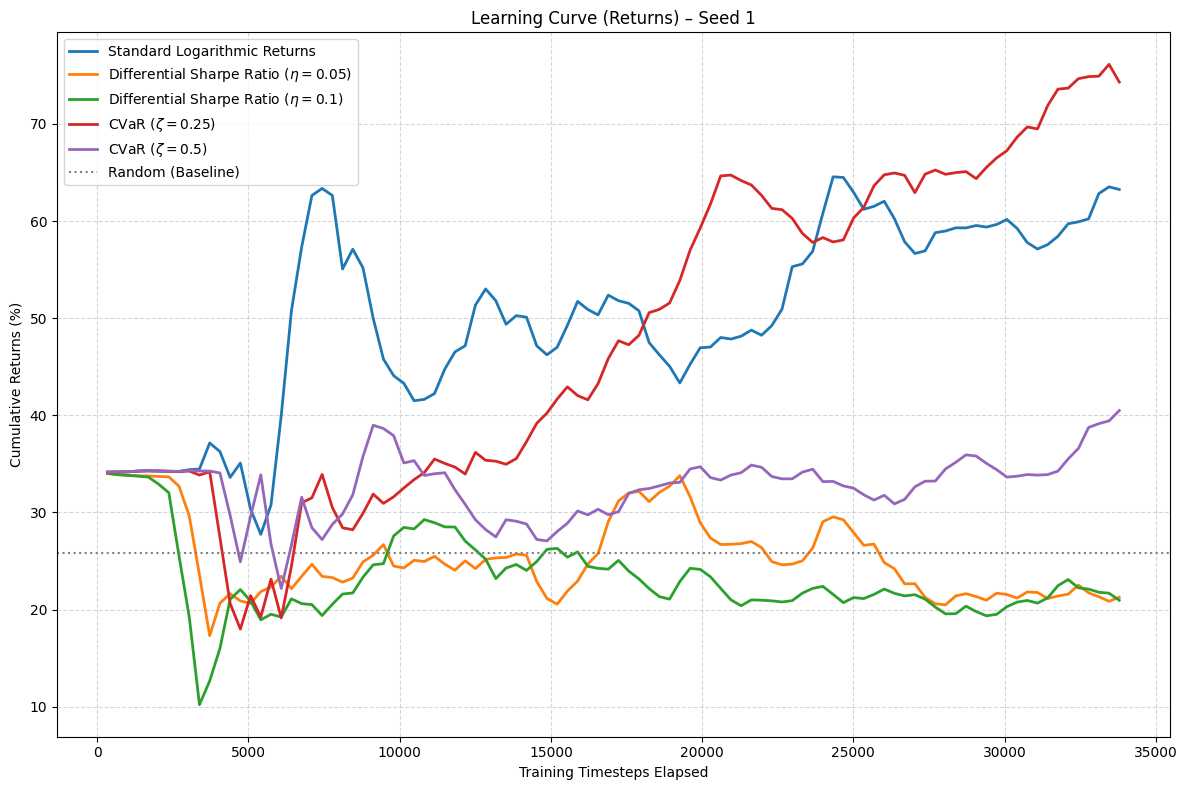

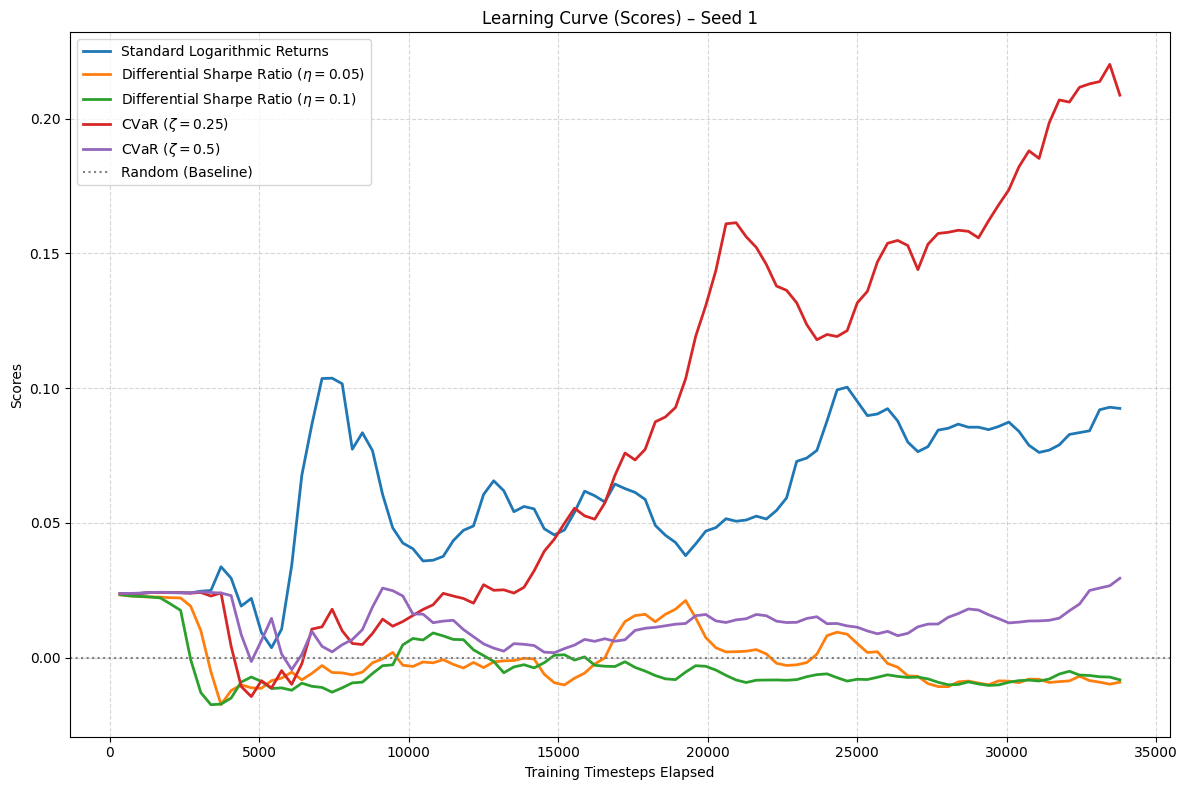

Seed 1: Best Agents and Their Test-Set Performance

Reward Function Cumulative Return Maximum Drawdown Sharpe Ratio Score Training Timesteps Elapsed 
 
 
 Standard Logarithmic Returns 63.3577 31.96 0.0883076 0.103709 7434 
 Differential Sharpe Ratio = 0.05 34.0044 25.2758 0.0718707 0.0232616 337 
 Differential Sharpe Ratio = 0.1 34.0363 25.273 0.0719351 0.0233758 337 
 CVaR = 0.25 76.1274 25.1815 0.110226 0.220191 33454 
 CVaR = 0.5 40.4893 34.005 0.0682775 0.0294467 33792

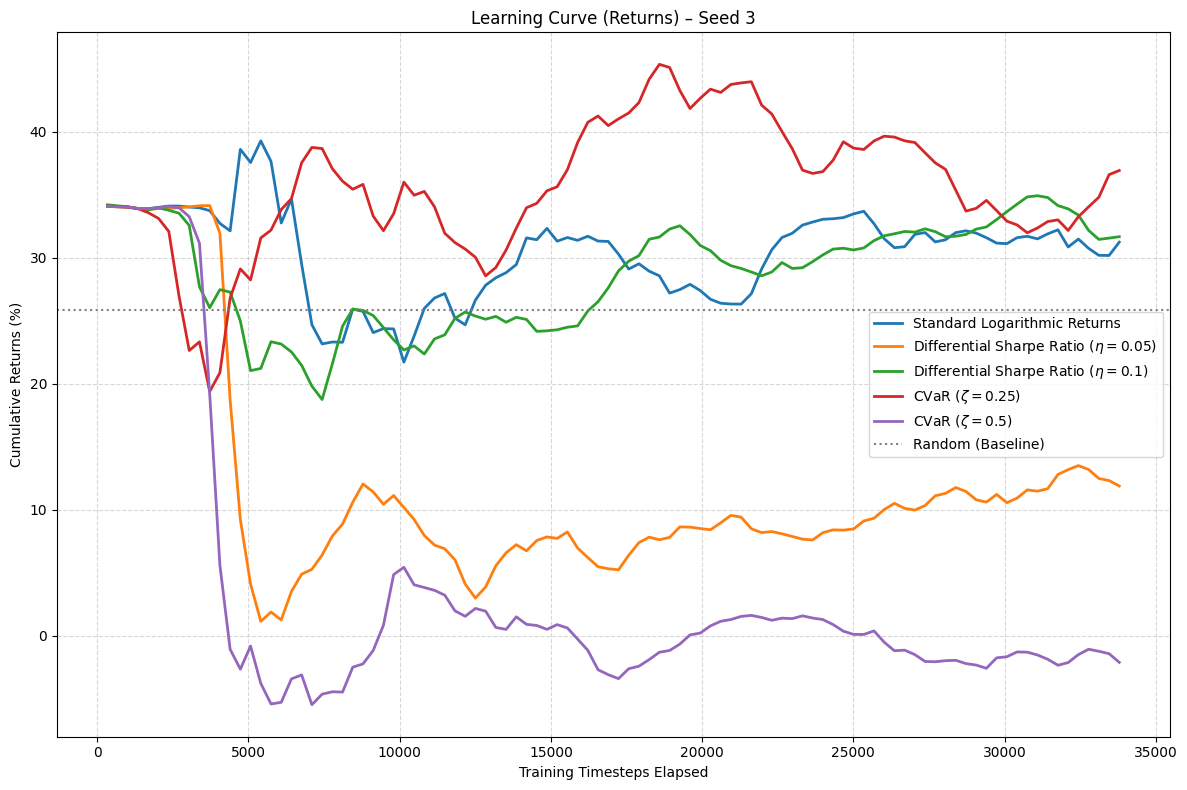

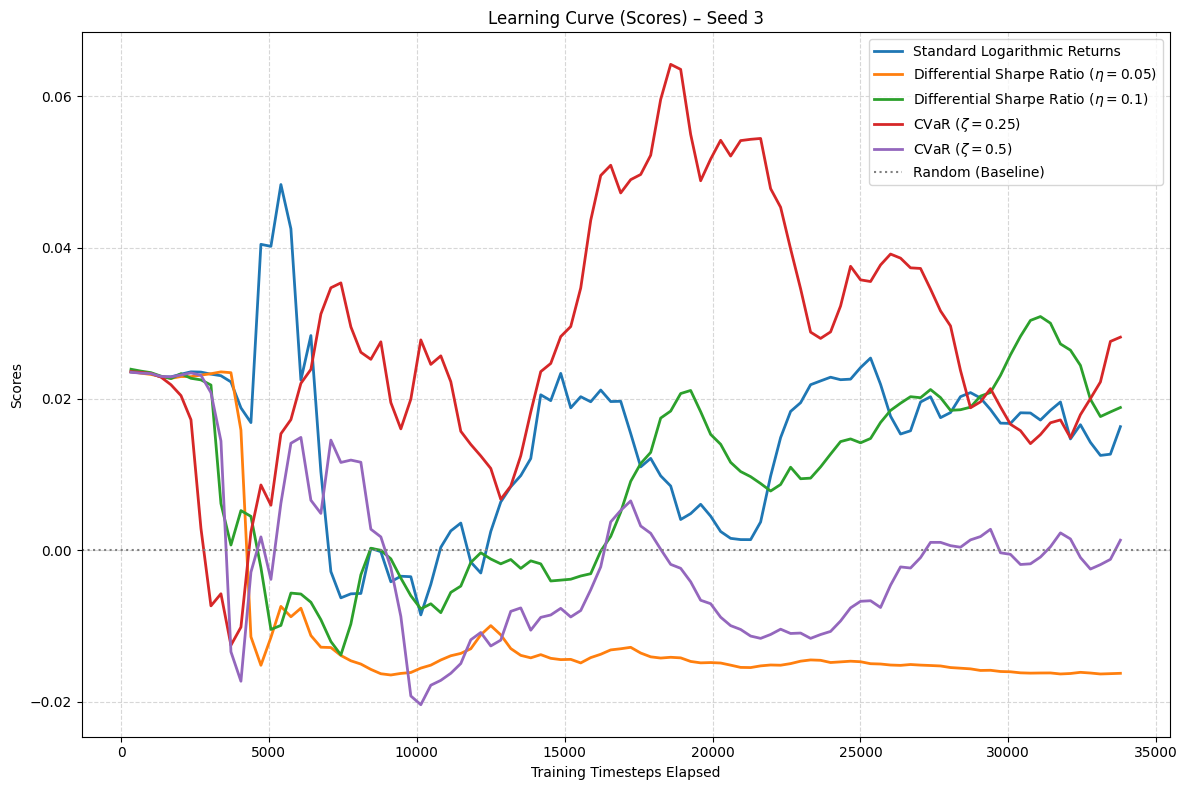

Seed 3: Best Agents and Their Test-Set Performance

Reward Function Cumulative Return Maximum Drawdown Sharpe Ratio Score Training Timesteps Elapsed 
 
 
 Standard Logarithmic Returns 39.2893 22.2039 0.079695 0.0483312 5406 
 Differential Sharpe Ratio = 0.05 34.115 25.2923 0.0720431 0.0236174 337 
 Differential Sharpe Ratio = 0.1 34.9318 22.8668 0.0775443 0.030887 31088 
 CVaR = 0.25 45.367 25.7382 0.0845638 0.0642104 18585 
 CVaR = 0.5 34.0866 25.2897 0.0719992 0.0235244 337

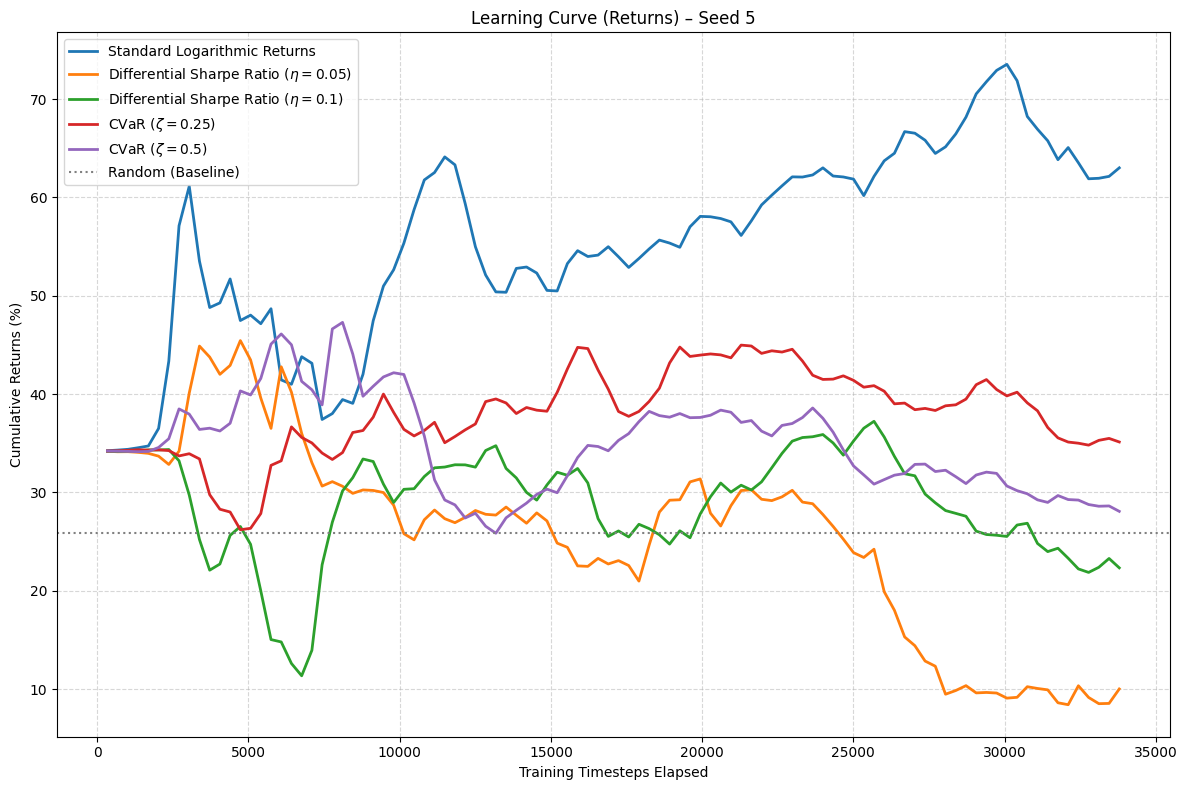

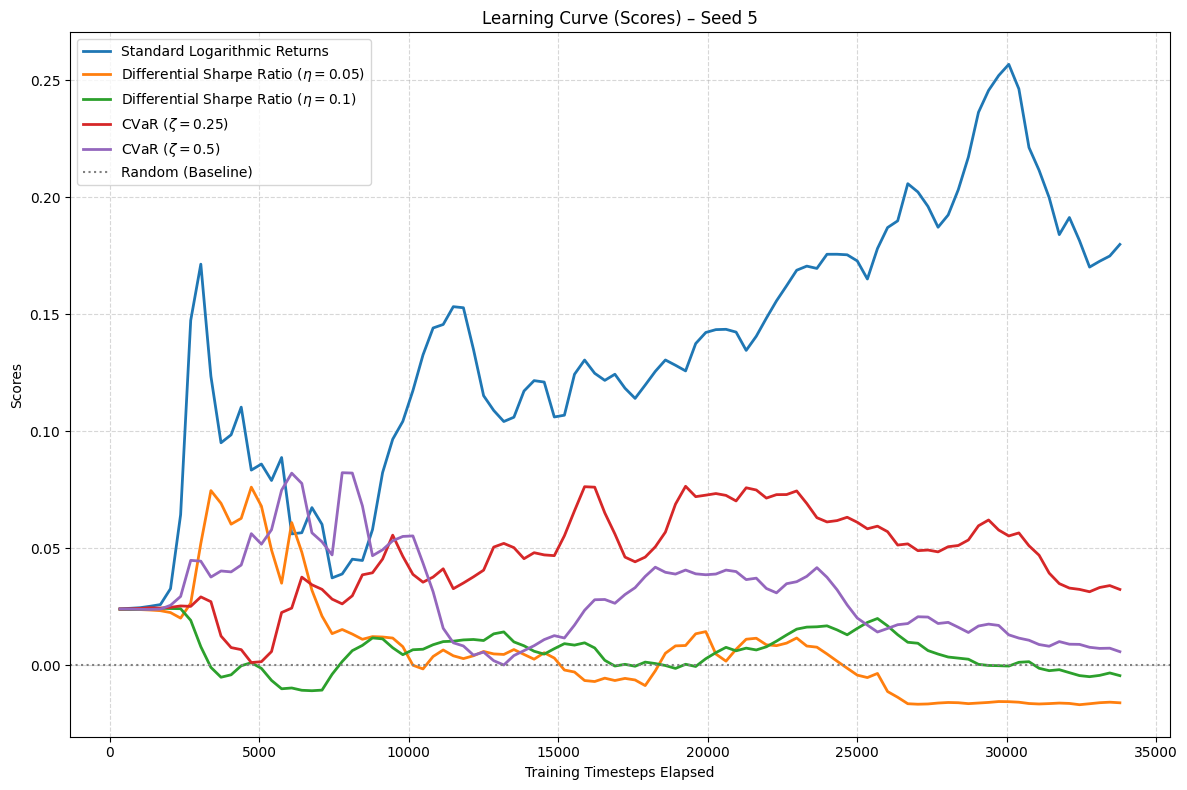

Seed 5: Best Agents and Their Test-Set Performance

Reward Function Cumulative Return Maximum Drawdown Sharpe Ratio Score Training Timesteps Elapsed 
 
 
 Standard Logarithmic Returns 73.5278 22.2506 0.119749 0.256736 30074 
 Differential Sharpe Ratio = 0.05 45.4356 22.5036 0.0872666 0.0760527 4730 
 Differential Sharpe Ratio = 0.1 34.3176 25.306 0.0723752 0.0242927 1689 
 CVaR = 0.25 44.7759 21.8487 0.0880977 0.0764187 19261 
 CVaR = 0.5 46.6208 21.7347 0.0859305 0.0822238 7772

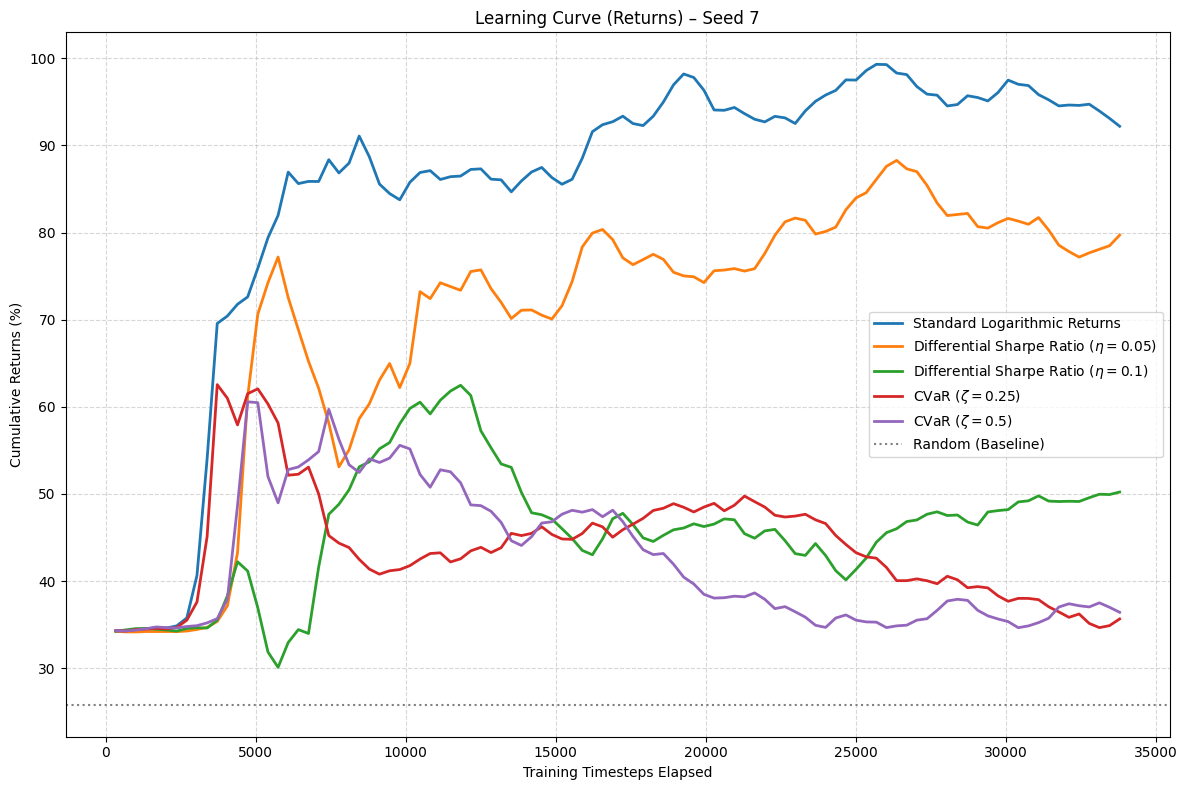

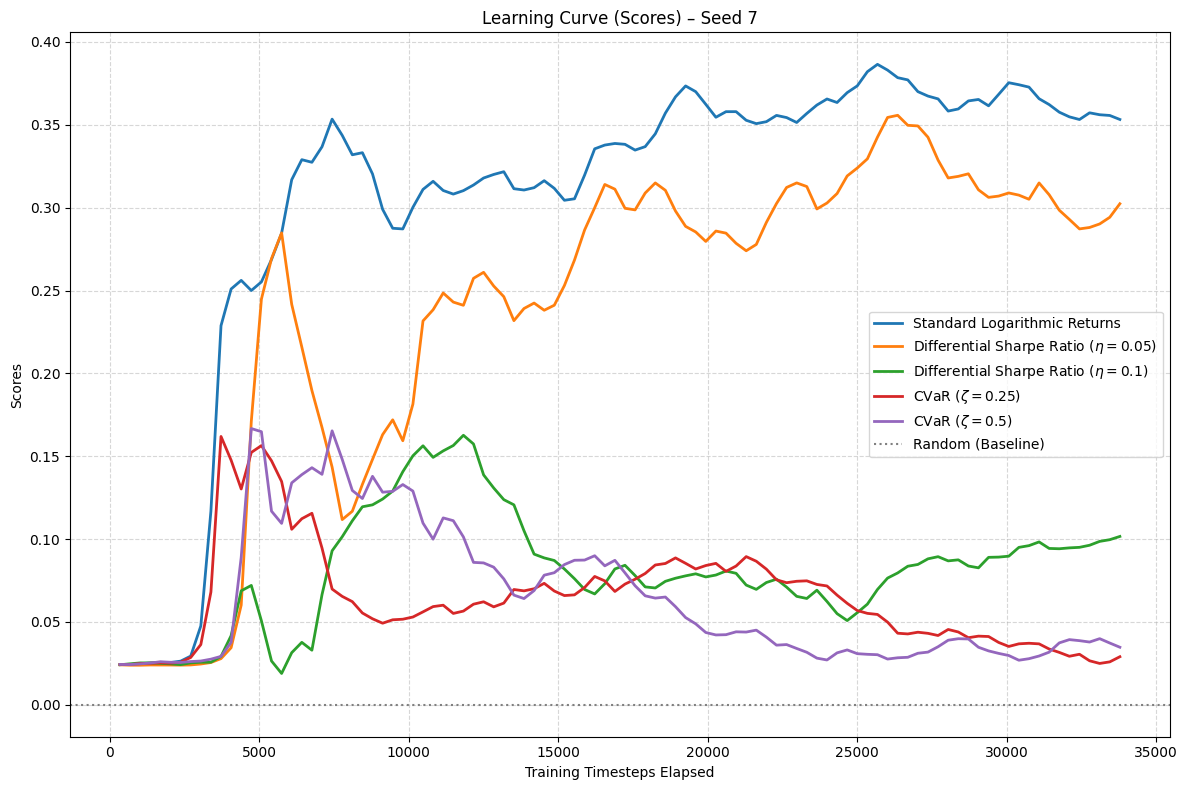

Seed 7: Best Agents and Their Test-Set Performance

Reward Function Cumulative Return Maximum Drawdown Sharpe Ratio Score Training Timesteps Elapsed 
 
 
 Standard Logarithmic Returns 99.2946 25.1714 0.132416 0.386499 25681 
 Differential Sharpe Ratio = 0.05 88.2721 23.3161 0.132824 0.355748 26357 
 Differential Sharpe Ratio = 0.1 62.4747 24.296 0.107801 0.16262 11827 
 CVaR = 0.25 62.5504 24.6132 0.108498 0.161895 3717 
 CVaR = 0.5 60.5752 23.0598 0.110606 0.166685 4730

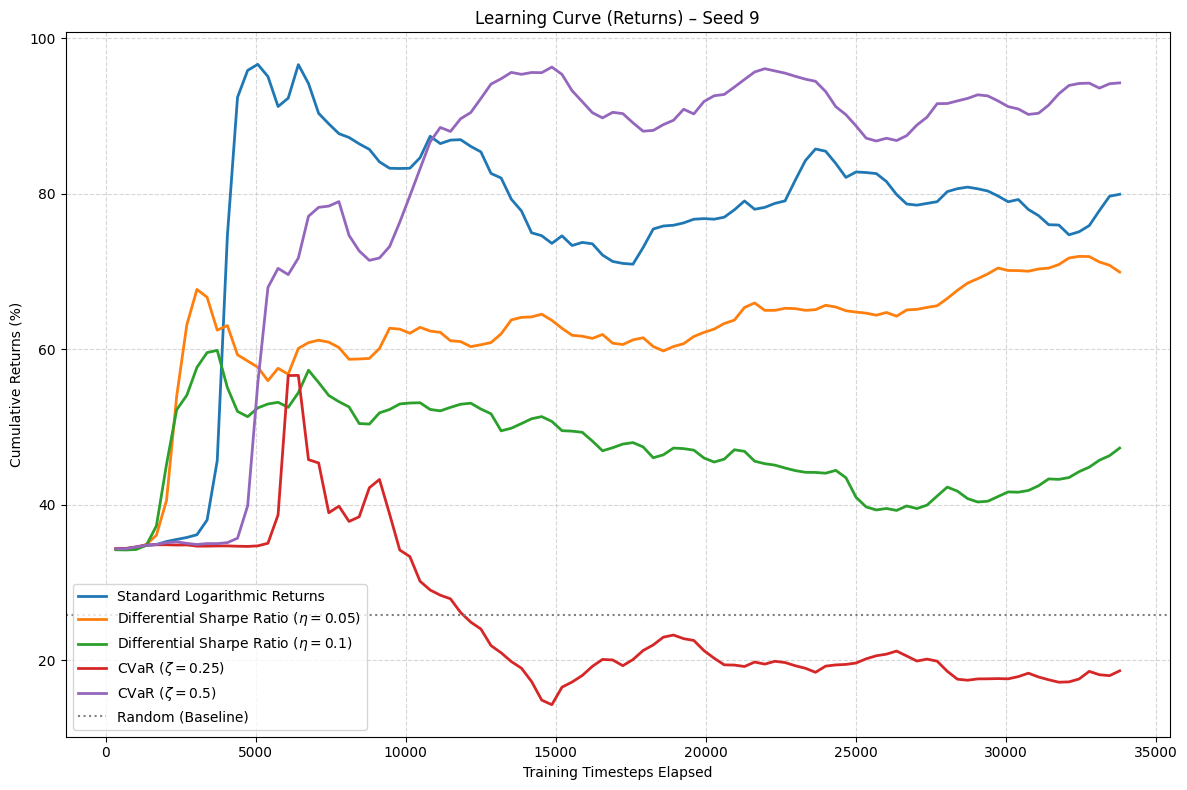

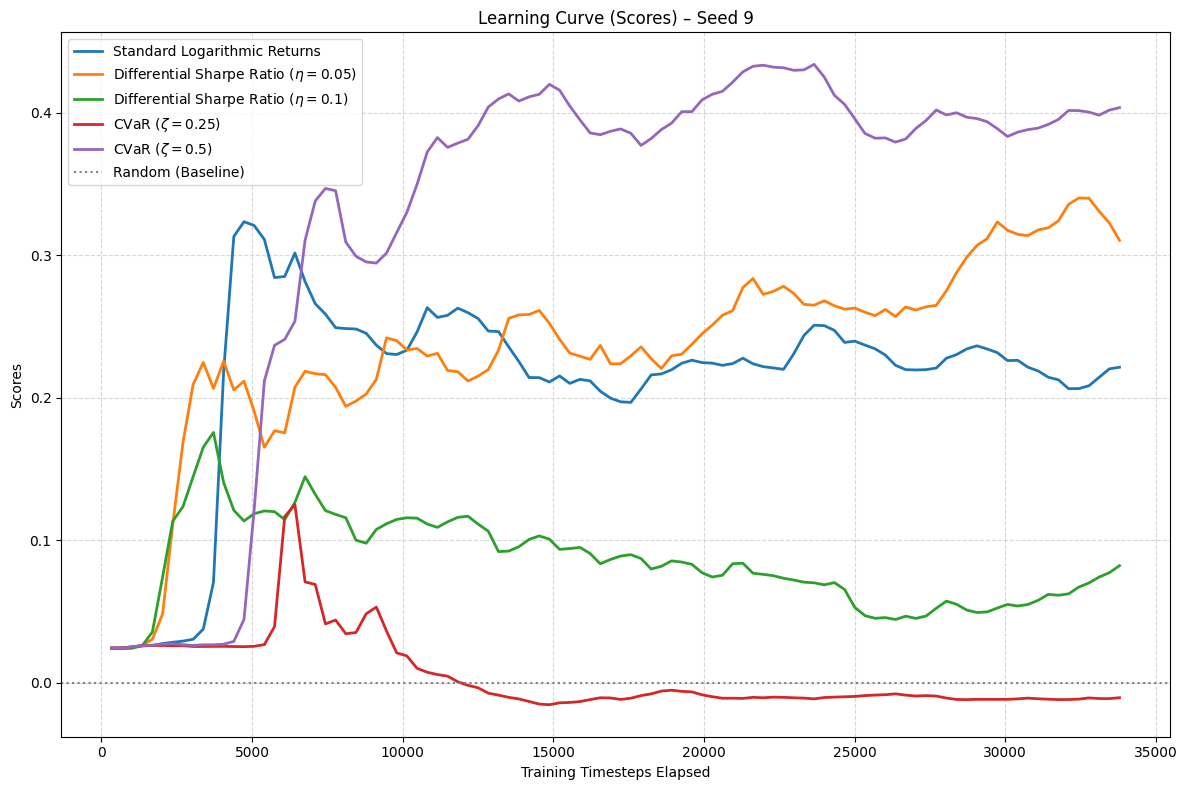

Seed 9: Best Agents and Their Test-Set Performance

Reward Function Cumulative Return Maximum Drawdown Sharpe Ratio Score Training Timesteps Elapsed 
 
 
 Standard Logarithmic Returns 95.8867 27.2383 0.125804 0.323596 4730 
 Differential Sharpe Ratio = 0.05 71.9488 17.4367 0.128614 0.34022 32440 
 Differential Sharpe Ratio = 0.1 59.8531 21.6767 0.111892 0.175655 3717 
 CVaR = 0.25 56.6294 24.3969 0.0989545 0.124948 6420 
 CVaR = 0.5 94.4842 22.3289 0.141156 0.434049 23654

In [ ]:
from itertools import cycle


portVals = dict()
FIG_SIZE = (12, 8)
for strat in NON_RL_COMPARISON_STRATEGIES:
    portVals[strat] = evaluateAgent("", "", "", "", "", "", conf=None, save=True, dataType = "testing", forLearningCurve=False, benchmark=False, epoch=0, showTable=False, compare=strat)
    
bestTestSetPerformance = dict()
WINDOW = 1 # raw
VARIED_BASE_SEEDS = [1, 3, 5, 7, 9]


"""
The below code generates more metrics and plots for the test set performance of the agents.
"""
def plotAllCurves(rewardFunctions):
    for seed in VARIED_BASE_SEEDS:
        cumulativeReturnsData = {}
        scoresData = {}
        timeSteps = []

        for rewardFunc in rewardFunctions:
            file = f"portfolios/testing/forLearningCurve{seed}/Reward Function-{rewardFunc}_"
            cumReturns = []
            scores = []
            for i in range(1, 101):
                key = f"{file}{i}.txt"
                values = np.loadtxt(key)
                metrics = scoreFormula(values, avRandReturn)
                cumReturns.append(metrics["Cumulative \nReturn (%)"])
                scores.append(metrics["Score"])
                if len(timeSteps) < 100:
                    timeSteps.append(i / 100 * SUM_TRAINING_PERIODS)
            cumulativeReturnsData[rewardFunc] = cumReturns
            scoresData[rewardFunc] = scores
            bestPercentThrough = np.argmax(scores)
            bestTestSetPerformance[(rewardFunc, seed)] = [
                max(cumReturns),
                scores[bestPercentThrough],
                int(timeSteps[bestPercentThrough])
            ]
            bestTestSetPerformance[(rewardFunc, seed)].append(np.loadtxt(f"{file}{bestPercentThrough + 1}.txt"))

        # Plot cumulative returns for this seed
        plt.figure(figsize=FIG_SIZE)
        for rewardFunc, cumReturns in cumulativeReturnsData.items():
            properName = rewardFunc.split('_')
            if len(properName) > 1:
                if "CVaR" in properName[0]:
                    plottedName = f"CVaR ($\\zeta={properName[1]}$)"
                elif "Differential Sharpe Ratio" in properName[0]:
                    plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
                else:
                    plottedName = f"{properName[0]} ({properName[1]})"
            else:
                plottedName = properName[0]
            smoothedReturns = np.convolve(cumReturns, np.ones(WINDOW)/WINDOW, mode='valid')
            plt.plot(timeSteps, np.append(cumReturns[:WINDOW-1], smoothedReturns),
                     label=plottedName, linewidth=2)
        plt.axhline(y=avRandReturn*100, color='grey', linestyle=':', label="Random (Baseline)", linewidth=1.5)
        plt.xlabel("Training Timesteps Elapsed")
        plt.ylabel("Cumulative Returns (%)")
        plt.title(f"Learning Curve (Returns) – Seed {seed}")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"plots/Cumulative_Returns_Seed{seed}")
        plt.show()

        # Plot scores for this seed
        plt.figure(figsize=FIG_SIZE)
        for rewardFunc, scores in scoresData.items():
            properName = rewardFunc.split('_')
            if len(properName) > 1:
                if "CVaR" in properName[0]:
                    plottedName = f"CVaR ($\\zeta={properName[1]}$)"
                elif "Differential Sharpe Ratio" in properName[0]:
                    plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
                else:
                    plottedName = f"{properName[0]} ({properName[1]})"
            else:
                plottedName = properName[0]
            smoothedScores = np.convolve(scores, np.ones(WINDOW)/WINDOW, mode='valid')
            plt.plot(timeSteps, np.append(scores[:WINDOW-1], smoothedScores),
                     label=plottedName, linewidth=2)
        plt.axhline(y=0, color='grey', linestyle=':', label="Random (Baseline)", linewidth=1.5)
        plt.xlabel("Training Timesteps Elapsed")
        plt.ylabel("Scores")
        plt.title(f"Learning Curve (Scores) – Seed {seed}")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"plots/Scores_Seed{seed}")
        plt.show()

        # Tabulate best agents for this seed
        table = [["Reward Function", "Cumulative Return", "Maximum Drawdown", "Sharpe Ratio", "Score", "Training Timesteps Elapsed"]]
        for rewardFunc in EXP_CONFIG["Reward"]:
            properName = rewardFunc.split('_')
            tabulatedName = f"{properName[0] + (f' = {properName[1]}' if len(properName) > 1 else '')}"
            metrics = scoreFormula(bestTestSetPerformance[(rewardFunc, seed)][-1], avRandReturn)
            table.append([
                tabulatedName, 
                metrics["Cumulative \nReturn (%)"], 
                metrics["Maximum \nDrawdown (%)"], 
                metrics["Sharpe Ratio"],
                metrics["Score"], 
                bestTestSetPerformance[(rewardFunc, seed)][2]
            ])
        tabulate_neatly(table, headers="firstrow", title=f"Seed {seed}: Best Agents and Their Test-Set Performance")




plotAllCurves(EXP_CONFIG["Reward"])


plt.figure(figsize=(10, 6))
availableColors = ['purple', 'darkgreen', 'darkgray', 'black', 'navy']
colorCycle = cycle(availableColors) 

for seed in VARIED_BASE_SEEDS:
    for rewardFunc in EXP_CONFIG["Reward"]:
        properName = rewardFunc.split('_')
        plottedName = f"{properName[0] + (f" = {properName[1]}" if len(properName) > 1 else "")}"
        plt.plot(np.array(bestTestSetPerformance[(rewardFunc, seed)][-1]) / START_CASH * 100 - 100, label=f"{plottedName}")
plt.ylabel("Cumulative Returns (%)")
plt.xlabel("Time")
plt.title("Cumulative Returns On Test Set")

plt.plot(np.array(averPerformance) / START_CASH * 100 - 100, label="Random (Baseline)", color="grey")
for key, value in portVals.items():
    color = next(colorCycle)  
    plt.plot(np.array(value) / START_CASH * 100 - 100, label=key, color=color)

plt.legend()
# plt.savefig("plots/BestRawReturnsAll")
# plt.show()
plt.close()
 
#########################################################################################################


### 5.4 Best Performances and Standard Deviations

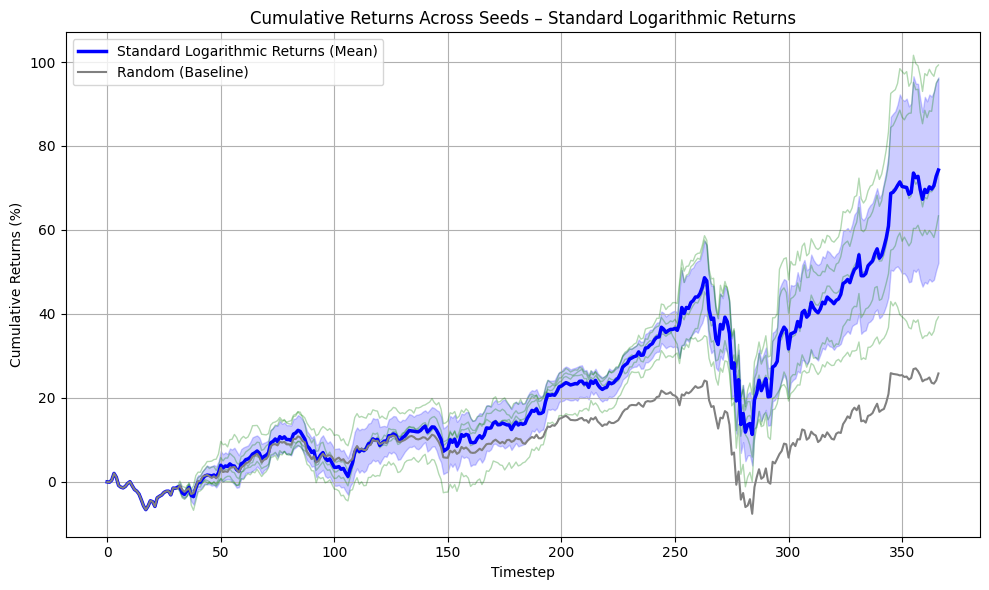

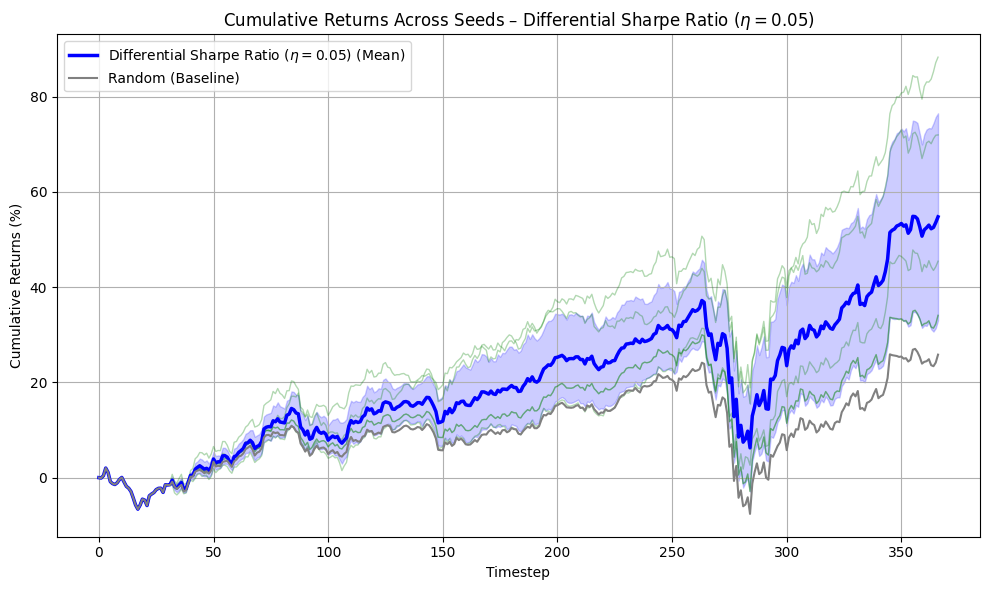

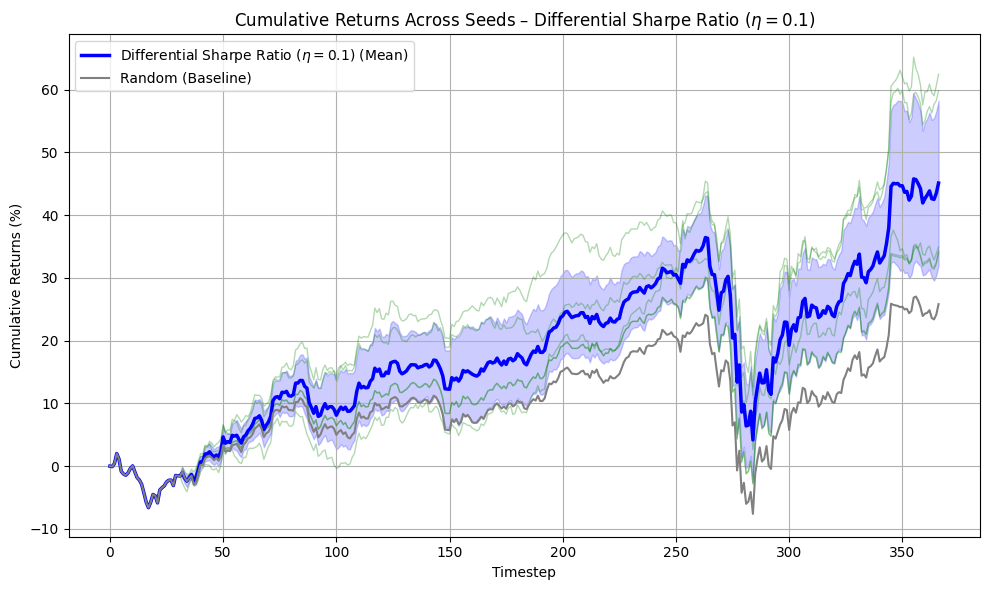

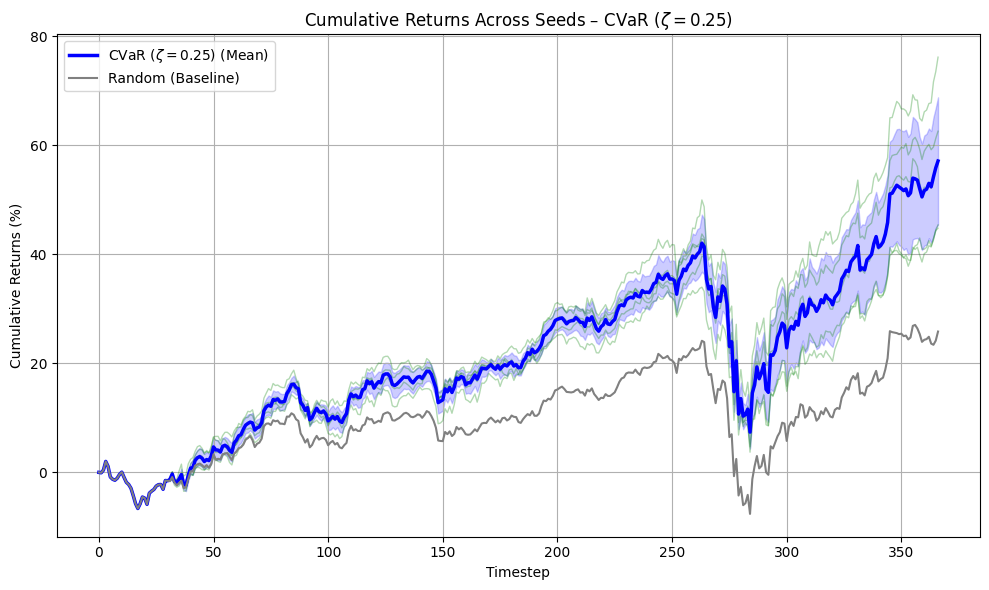

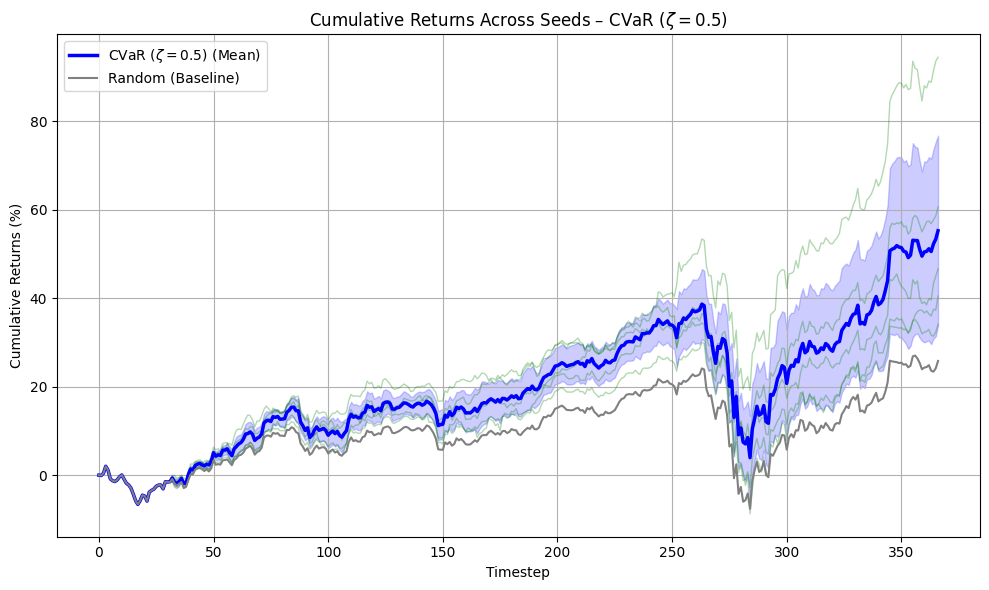

In [ ]:

for rewardFunc in EXP_CONFIG["Reward"]:
    allTrajectories = []
    for seed in VARIED_BASE_SEEDS:
        traj = np.array(bestTestSetPerformance[(rewardFunc, seed)][-1]) / START_CASH * 100 - 100
        allTrajectories.append(traj)

    # Convert to array for mean/std computation
    allTrajectories = np.array(allTrajectories)
    meanTrajectory = np.mean(allTrajectories, axis=0)
    std_traj = np.std(allTrajectories, axis=0)
    timesteps = np.arange(len(meanTrajectory))

    # Format name for legend and title
    properName = rewardFunc.split('_')
    if len(properName) > 1:
        if "CVaR" in properName[0]:
            plottedName = f"CVaR ($\\zeta={properName[1]}$)"
        elif "Differential Sharpe Ratio" in properName[0]:
            plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
        else:
            plottedName = f"{properName[0]} ({properName[1]})"
    else:
        plottedName = properName[0]

    # Plot
    plt.figure(figsize=(10, 6))
    for traj in allTrajectories:
        plt.plot(timesteps, traj, color='green', alpha=0.3, linewidth=1)  # Faint individual runs
    plt.plot(timesteps, meanTrajectory, color='blue', label=f"{plottedName} (Mean)", linewidth=2.5)
    plt.plot(np.array(averPerformance) / START_CASH * 100 - 100, label="Random (Baseline)", color="grey")
    plt.fill_between(timesteps, meanTrajectory - std_traj, meanTrajectory + std_traj, color='blue', alpha=0.2)
    # Clean filename string: replace space, dot, brackets, equal signs

    safe_filename = rewardFunc.replace(' ', '_').replace('=', '').replace('(', '').replace(')', '').replace('.', '_')

    plt.xlabel("Timestep")
    plt.ylabel("Cumulative Returns (%)")
    plt.title(f"Cumulative Returns Across Seeds – {plottedName}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/Cumulative_Returns_Mean_{safe_filename}")
    plt.show()


### 5.5 Means and Index Comparisons

In [ ]:
meanStdPerReward = {}

for rewardFunc in EXP_CONFIG["Reward"]:
    allTrajectories = []
    mdds = []
    sharpes = []
    scores = []

    for seed in VARIED_BASE_SEEDS:
        traj = np.array(bestTestSetPerformance[(rewardFunc, seed)][-1])
        normTraj = traj / START_CASH * 100 - 100  # Percentage returns for plotting
        allTrajectories.append(normTraj)

        # Compute MDD and Sharpe on raw values
        raw = traj
        
        mdd = maxDrawdown(raw) * 100  # convert to percent
        returns = np.diff(raw) / raw[:-1]
        sharpe = np.mean(returns) / np.std(returns) if np.std(returns) != 0 else 0

        mdds.append(mdd)
        sharpes.append(sharpe)
        metrs = scoreFormula(traj, avRandReturn)
        scores.append(metrs["Score"])

    allTrajectories = np.array(allTrajectories)
    mean_traj = np.mean(allTrajectories, axis=0)
    std_traj = np.std(allTrajectories, axis=0)

    meanStdPerReward[rewardFunc] = {
        "mean_trajectory": mean_traj,
        "std_trajectory": std_traj,
        "final_mean_return": mean_traj[-1],
        "final_std_dev": np.std([traj[-1] for traj in allTrajectories]),
        "mean_mdd": np.mean(mdds),
        "mean_sharpe": np.mean(sharpes),
        "mean_score": np.mean(scores),
    }

# Optional: print or tabulate results
indexComparisonTable = [["Reward Function", "Final Mean Return (%)", "Std Dev (%)", "Mean MDD (%)", "Mean Sharpe", "Mean Score"]]
for rewardFunc in EXP_CONFIG["Reward"]:
    properName = rewardFunc.replace("_", " = ") if "_" in rewardFunc else rewardFunc
    stats = meanStdPerReward[rewardFunc]
    indexComparisonTable.append([
        properName,
        round(stats["final_mean_return"], 4),
        round(stats["final_std_dev"], 4),
        round(stats["mean_mdd"], 4),
        round(stats["mean_sharpe"], 4),
        round(stats["mean_score"], 4)
    ])

tabulate_neatly(indexComparisonTable, headers="firstrow", title="Mean Statistics Across Seeds")



Mean Statistics Across Seeds

Reward Function Final Mean Return (%) Std Dev (%) Mean MDD (%) Mean Sharpe Mean Score 
 
 
 Standard Logarithmic Returns 74.2712 22.0762 25.7648 0.1092 0.2238 
 Differential Sharpe Ratio = 0.05 54.7552 21.7369 22.7649 0.0985 0.1638 
 Differential Sharpe Ratio = 0.1 45.1227 13.127 23.8837 0.0883 0.0834 
 CVaR = 0.25 57.09 11.6749 24.3557 0.0981 0.1295 
 CVaR = 0.5 55.2512 21.4844 25.2836 0.0956 0.1472

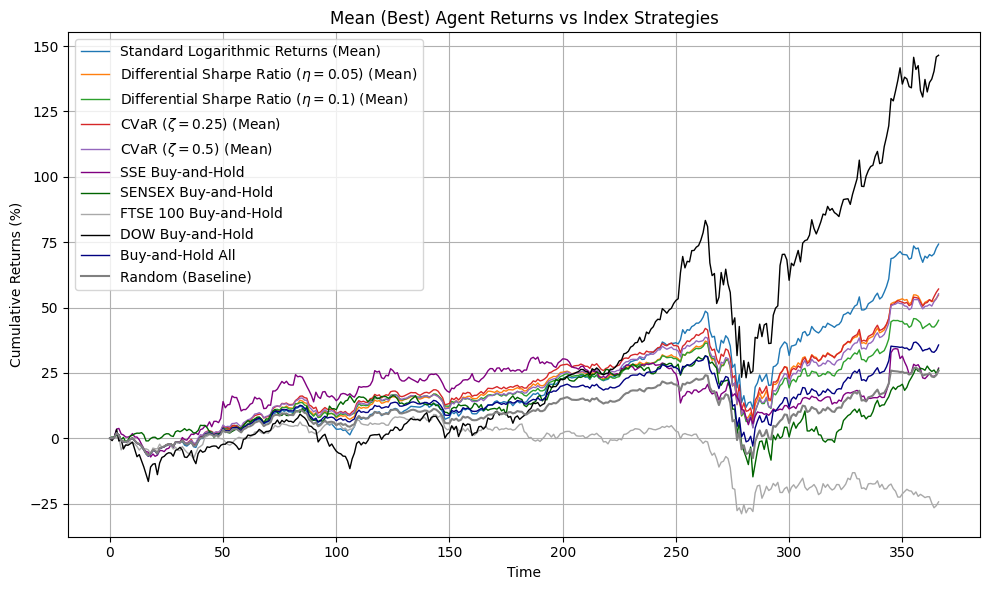

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

# Define figure and color cycle
plt.figure(figsize=(10, 6))
availableColors = ['purple', 'darkgreen', 'darkgray', 'black', 'navy']
colorCycle = cycle(availableColors)

# Plot mean RL trajectories across seeds
for rewardFunc in EXP_CONFIG["Reward"]:
    allTrajectories = []
    for seed in VARIED_BASE_SEEDS:
        traj = np.array(bestTestSetPerformance[(rewardFunc, seed)][-1]) / START_CASH * 100 - 100
        allTrajectories.append(traj)
    meanTrajectory = np.mean(allTrajectories, axis=0)
    timesteps = np.arange(len(meanTrajectory))

    # Format name for legend
    properName = rewardFunc.split('_')
    if len(properName) > 1:
        if "CVaR" in properName[0]:
            plottedName = f"CVaR ($\\zeta={properName[1]}$)"
        elif "Differential Sharpe Ratio" in properName[0]:
            plottedName = f"Differential Sharpe Ratio ($\\eta={properName[1]}$)"
        else:
            plottedName = f"{properName[0]} ({properName[1]})"
    else:
        plottedName = properName[0]

    plt.plot(timesteps, meanTrajectory, label=f"{plottedName} (Mean)", linewidth=1)

# Plot index strategies from portVals with custom dash style
for key, value in portVals.items():
    traj = np.array(value) / START_CASH * 100 - 100
    color = next(colorCycle)
    plt.plot(traj, label=key, color=color, linewidth=1)
plt.plot(np.array(averPerformance) / START_CASH * 100 - 100, label="Random (Baseline)", color="grey")


# Add baseline and labels
plt.xlabel("Time")
plt.ylabel("Cumulative Returns (%)")
plt.title("Mean (Best) Agent Returns vs Index Strategies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/Mean_Returns_vs_Indices")
plt.show()
